<a href="https://colab.research.google.com/github/JackGraymer/Advanced-GenAI/blob/finishing-2.1/2.1_rag_research_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Generative Artificial Intelligence
**Project - Designing a RAG-Based Q&A System for News Retrieval**

**Authors:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan (Group 5)


# Step 2.1 - Building the RAG System: Research Agents -<br> Implementing multiple pre-retrieval and retrieval strategies

**Contribution:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan

**Goal of this step:** Implementing and comparing diﬀerent pre-retrieval and retrieval strategies to extract relevant candidate documents. These retrieved documents will go through the post-retrieval process in Step 2.2.

#  1.0 Data Preprocessing and Benchmark Construction

## 1.1 Setup of the environment

### Installations and loading of packages

In [ ]:
!pip install torch torchvision torchaudio

In [1]:
import torch
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    # The model will automatically be placed on the GPU
else:
    print("GPU is not available. Running on CPU.")

GPU is available: NVIDIA A100-SXM4-40GB


In [ ]:
!pip install sentence-transformers faiss-cpu

In [ ]:
!pip install langchain langchain_groq

Below the necessary libraries are installed and loaded into the environment.

In [2]:
import os
import re
import json
import asyncio
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pprint
import pickle
import faiss
from sentence_transformers import SentenceTransformer

In [9]:
# Allows asyncio to run in a notebook environment
import nest_asyncio
nest_asyncio.apply()

# Import LangChain components
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnableConfig

### Setting seeds and mounting Google Drive storage folder

In [10]:
# Set the seed for consistent results
seed_value = 2138247234
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

Below we mount a shared Google Drive folder as a data storage and define the base path of the folder that will be used in the runtime.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

### Check properties of environment

In [ ]:
!nvidia-smi

Sun May 25 12:08:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   39C    P8             16W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.2
astropy-iers-data                     0.2025.5.12.0.38.29
astunparse                            1

## 1.2 Loading the dataset from stage 1

In [13]:
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Final-Datasets/Stage1-final.csv'))

In [14]:
df.head()

,folder_path,file_name,year,month,language,type,title,content,named_entities,topics,keywords,summary
0,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,"Als 1950 die Meteorologen Jule Charney, Ragnar...","[('CO2', 'MISC'), ('Klimamodelle\n\n', 'PER'),...","['klimamodelle', 'prozesse', 'modelle', 'gitte...","['wetterprognose', 'wettermodellen', 'precipit...","Geht es aber darum, wie häufig heisse und glei..."
1,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,scientifica-teaser-kerosin-aus-luft.html,2019,8,de,news events,Scientifica teaser kerosin aus luft,"Vieles, womit sich Wissenschaftlerinnen und Wi...","[('Schweiz', 'LOC'), ('Scientifica', 'LOC'), (...","['science', 'scientifica', 'wissenschaftlerinn...","['wissenschaftsfestival', 'wissenschaftlerinne...","Vieles, womit sich Wissenschaftlerinnen und Wi..."
2,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kraftwerk-vor-dem-fenster.html,2019,8,de,news events,Kraftwerk vor dem fenster,Gebäude zu heizen oder zu kühlen benötigt Ener...,"[('Komfort', 'LOC'), ('Nature Energy 4', 'MISC...","['fassade', 'energie', 'gebäude', 'raum', 'pro...","['energiesparpotenzial', 'gebäudesysteme', 'so...",Die Wirkung der adaptiven Solarfassade wird Sc...
3,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,eth-plus-initiativen.html,2019,8,de,news events,Eth plus initiativen,"Das Interesse an ETH+, in dessen Rahmen bereit...","[('Zentrum', 'ORG'), ('ETH', 'ORG'), ('ETH Zür...","['eth', 'professur', 'zusammenarbeit', 'bereic...","['ausgezeichneten', 'eth', 'elektronengetriebe...","Das Interesse an ETH+, in dessen Rahmen bereit..."
4,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kuenstliche-intelligenz-im-podcast.html,2019,8,de,news events,Kuenstliche intelligenz im podcast,Künstliche Intelligenz und maschinelles Lernen...,"[('Benjamin Grewe', 'PER'), ('ETH Zürich', 'OR...","['intelligenz', 'sprechen', 'science', 'maschi...","['technologien', 'künstlichen', 'künstliche', ...",Im Podcast sprechen wir mit den ETH-Professore...


Below we plot the dataframe sorted by the length of the `content` column. We will remove the rows where the content is less than 45 characters, since those texts don't provide any useful information.

In [ ]:
print(df.shape)

(4351, 12)


In [ ]:
# sort df by lenght of context ascending
df.sort_values(by='content', key=lambda x: x.str.len(), ascending=True).head(10)

,folder_path,file_name,year,month,language,type,title,content,named_entities,topics,keywords,summary
1143,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,medienmitteilung-stop-hate-speech-alliance-f-u...,2023,2,de,news events,Medienmitteilung stop hate speech alliance f u...,## Kontakt,[],['kontakt'],['kontakt'],## Kontakt
4081,/content/drive/MyDrive/AdvGenAI/data/en_news_e...,medienmitteilung-stop-hate-speech-alliance-f-u...,2023,2,en,news events,Medienmitteilung stop hate speech alliance f u...,## Contact,"[('## Contact', 'MONEY')]",['contact'],['contact'],## Contact
1705,/content/drive/MyDrive/AdvGenAI/data/de_intern...,mendeley-literaturverwaltung.html,2014,1,de,internal,Mendeley literaturverwaltung,Weitere Informationen\n\n,[],['informationen'],"['weitere', 'informationen']",Weitere Informationen
1749,/content/drive/MyDrive/AdvGenAI/data/de_intern...,citavi-literaturverwaltung.html,2014,2,de,internal,Citavi literaturverwaltung,Weitere Informationen\n\n,[],['informationen'],"['weitere', 'informationen']",Weitere Informationen
1704,/content/drive/MyDrive/AdvGenAI/data/de_intern...,web-of-science-alles-neu-macht-der--januar-.html,2014,1,de,internal,Web of science alles neu macht der januar,Weitere Informationen\n\n,[],['informationen'],"['weitere', 'informationen']",Weitere Informationen
2262,/content/drive/MyDrive/AdvGenAI/data/de_intern...,usa-fulbright-specialist-program.html,2024,6,de,internal,Usa fulbright specialist program,Siehe Details auf der englischen Webseite.,"[('englischen', 'MISC')]","['details', 'englischen', 'siehe', 'webseite']","['webseite', 'englischen', 'siehe', 'auf', 'der']",Siehe Details auf der englischen Webseite.
2217,/content/drive/MyDrive/AdvGenAI/data/de_intern...,usa-fulbright-specialist-program.html,2024,1,de,internal,Usa fulbright specialist program,Siehe Details auf der englischen Webseite.,"[('englischen', 'MISC')]","['details', 'englischen', 'webseite', 'siehe']","['webseite', 'englischen', 'siehe', 'auf', 'der']",Siehe Details auf der englischen Webseite.
2549,/content/drive/MyDrive/AdvGenAI/data/en_intern...,had-enough-of-long-training-courses.html,2014,10,en,internal,Had enough of long training courses,The events take place from 12.15 to 12.30:\n\n,"[('12.30', 'CARDINAL'), ('12.15', 'CARDINAL')]","['events', 'place']","['events', '12', '15', '30', 'place']",The events take place from 12.15 to 12.30:
1740,/content/drive/MyDrive/AdvGenAI/data/de_intern...,tablets-fuer-studium-und-arbeit--betriebssyste...,2014,4,de,internal,Tablets fuer studium und arbeit betriebssystem...,Themen:\n\nWeitere Informationen und Anmeldung...,[],"['anmeldung', 'informationen', 'themen']","['informationen', 'weitere', 'anmeldung', 'the...",Themen: Weitere Informationen und Anmeldung
1399,/content/drive/MyDrive/AdvGenAI/data/de_intern...,together-2018.html,2018,9,de,internal,Together 2018,## Impressionen\n\nBilder: ETH Zürich / Alessa...,"[('Alessandro Della Bella\n\n', 'PER'), ('ETH ...","['alessandro', 'bella', 'bilder', 'della', 'et...","['zürich', 'impressionen', 'alessandro', 'dell...",## Impressionen Bilder: ETH Zürich / Alessandr...


In [ ]:
df = df[df['content'].str.len() > 45]
print(df.shape)

(4343, 12)


For easier handling in the following steps we add an ID for each row starting at "0000" (including leading zeros).

In [ ]:
df = df.reset_index(drop=True)
df.insert(0, 'text_id', df.index.astype(str).str.zfill(4))

In [ ]:
df.head()

,text_id,folder_path,file_name,year,month,language,type,title,content,named_entities,topics,keywords,summary
0,0000,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,"Als 1950 die Meteorologen Jule Charney, Ragnar...","[('CO2', 'MISC'), ('Klimamodelle\n\n', 'PER'),...","['klimamodelle', 'prozesse', 'modelle', 'gitte...","['wetterprognose', 'wettermodellen', 'precipit...","Geht es aber darum, wie häufig heisse und glei..."
1,0001,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,scientifica-teaser-kerosin-aus-luft.html,2019,8,de,news events,Scientifica teaser kerosin aus luft,"Vieles, womit sich Wissenschaftlerinnen und Wi...","[('Schweiz', 'LOC'), ('Scientifica', 'LOC'), (...","['science', 'scientifica', 'wissenschaftlerinn...","['wissenschaftsfestival', 'wissenschaftlerinne...","Vieles, womit sich Wissenschaftlerinnen und Wi..."
2,0002,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kraftwerk-vor-dem-fenster.html,2019,8,de,news events,Kraftwerk vor dem fenster,Gebäude zu heizen oder zu kühlen benötigt Ener...,"[('Komfort', 'LOC'), ('Nature Energy 4', 'MISC...","['fassade', 'energie', 'gebäude', 'raum', 'pro...","['energiesparpotenzial', 'gebäudesysteme', 'so...",Die Wirkung der adaptiven Solarfassade wird Sc...
3,0003,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,eth-plus-initiativen.html,2019,8,de,news events,Eth plus initiativen,"Das Interesse an ETH+, in dessen Rahmen bereit...","[('Zentrum', 'ORG'), ('ETH', 'ORG'), ('ETH Zür...","['eth', 'professur', 'zusammenarbeit', 'bereic...","['ausgezeichneten', 'eth', 'elektronengetriebe...","Das Interesse an ETH+, in dessen Rahmen bereit..."
4,0004,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kuenstliche-intelligenz-im-podcast.html,2019,8,de,news events,Kuenstliche intelligenz im podcast,Künstliche Intelligenz und maschinelles Lernen...,"[('Benjamin Grewe', 'PER'), ('ETH Zürich', 'OR...","['intelligenz', 'sprechen', 'science', 'maschi...","['technologien', 'künstlichen', 'künstliche', ...",Im Podcast sprechen wir mit den ETH-Professore...


In [ ]:
# save dataset
df.to_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-01-loaded-dataset.csv'), index=False)

## 1.3 Chunking of the news texts

In [7]:
# Load dataset
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-01-loaded-dataset.csv'))

In this section we chunk our contents into smaller chunks. There are many different chunking methods. Since the text are in a markdown structure we will define a chunker that utilizes the properties of the markdown format by splitting the documents before the section headers.

After this splitting, not all parts have a reasonable length. Therefore we first merge chunks that are too small with the proceeding chunk. After that we go through the chunks and split those that are too large using a `RecursiveCharacterTextSplitter` with a defined chunk overlap. Since this Splitter might return chunks smaller than the defined minimum we had to rerun the step of adding too small chunks to previous ones and as a last step splitting the chunks that are too large into two parts with an added overlap.

The minimal length of a chunk should be set so is long enough to contain information and meaning. For the maximum length we look back at previous projects. For example in CLT we built upon an existing RAG pipeline by Daniel Perruchoud and George Rowlands ([Github](https://github.com/LuciferUchiha/Cleantech-RAG/tree/main)). There a maximum length of 1024 characters showed good results.

Since the chunks will be used for embeddings it makes sense to look at the model cards and especially the Intended uses and the training we can discover that many sentence embedding models were trained with a context length of 256 tokens, even though some allow an input of 512 or more tokens when using the models. Others will simply trunctuate at 256 tokens. With an average length of 4 characters per token we get 1024 characters, therefore in general allowing the use of the whole context of the chunk for the embedding.

After trying different settings we decide on a min. chunk size of 150 characters, max. chunk size of 1000 characters and a chunk overlap of 200 characters (if recursive splitting is necessary).

In [ ]:
import re
from typing import List
# Assuming RecursiveCharacterTextSplitter is available from langchain.text_splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

class HierarchicalRecursiveTextSplitter:
    def __init__(self, min_chunk_size=150, max_chunk_size=1000, chunk_overlap=200):
        self.min_chunk_size = min_chunk_size
        self.max_chunk_size = max_chunk_size
        self.chunk_overlap = chunk_overlap
        self.recursive_splitter = RecursiveCharacterTextSplitter(
            separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],
            chunk_size=self.max_chunk_size,
            chunk_overlap=self.chunk_overlap,
            length_function=len,
        )

    def split_by_header(self, text: str) -> List[str]:
        # Use multiline matching to split on header lines starting with '## '
        pattern = re.compile(r'(^## .+$)', flags=re.MULTILINE)
        splits = pattern.split(text)

        chunks = []
        # The first element of splits is the text before the first header
        if splits[0] and splits[0].strip():
            chunks.append(splits[0].strip())

        # Iterate through the rest, pairing header with its content
        for i in range(1, len(splits), 2):
            header = splits[i].strip()
            content = splits[i + 1].strip() if (i + 1) < len(splits) else ""
            chunk_text = f"{header}\n{content}".strip()
            if chunk_text:
                chunks.append(chunk_text)

        # Clean up excessive newlines
        for i in range(len(chunks)):
            chunks[i] = re.sub(r'\n{2,}', '\n', chunks[i])
        return chunks

    def recursive_split(self, chunks: List[str]) -> List[str]:
        final_chunks = []
        for chunk in chunks:
            if len(chunk) > self.max_chunk_size:
                # Recursively split large chunks
                smaller_chunks = self.recursive_splitter.split_text(chunk)
                final_chunks.extend(smaller_chunks)
            else:
                final_chunks.append(chunk)
        return final_chunks

    def merge_small_chunks(self, chunks: List[str]) -> List[str]:
        n = len(chunks)
        if n < 2:
            return chunks

        processed_chunks = []
        # --- Step 1: Handle the first two chunks (chunks[0] and chunks[1])
        first_chunk = chunks[0]
        second_chunk = chunks[1]
        # If either the first or the second chunk (or both) is small...
        if len(first_chunk) < self.min_chunk_size or len(second_chunk) < self.min_chunk_size:
            processed_chunks.append(first_chunk + "\n" + second_chunk)
        else:
            # Neither the first nor the second chunk is small. Add them separately.
            processed_chunks.append(first_chunk)
            processed_chunks.append(second_chunk)

        # --- Step 2: Loop for remaining chunks (from index 2 onwards)
        for i in range(2, n):
            current_chunk = chunks[i]
            # Check if the current chunk is smaller than the minimum required size.
            if len(current_chunk) < self.min_chunk_size:
                processed_chunks[-1] = processed_chunks[-1] + "\n" + current_chunk
            else:
                # Current chunk is not small. Add it as a new chunk.
                processed_chunks.append(current_chunk)
        return processed_chunks

    def split_too_large_chunks(self, chunks: List[str]) -> List[str]:
        final_chunks = []
        for chunk in chunks:
            if len(chunk) > self.max_chunk_size:
                mid_point = len(chunk) // 2
                overlap_half = self.chunk_overlap // 2
                start_of_second_chunk = mid_point - overlap_half
                end_of_first_chunk = mid_point + overlap_half
                chunk1 = chunk[:end_of_first_chunk]
                chunk2 = chunk[start_of_second_chunk:]
                final_chunks.extend([chunk1, chunk2])
            else:
                final_chunks.append(chunk)
        return final_chunks

    def split_text(self, text: str) -> List[str]:
        # 1. Split hierarchically by header
        header_chunks = self.split_by_header(text)
        # 2. Merge small chunks to enforce min_chunk_size.
        merged_chunks = self.merge_small_chunks(header_chunks)
        # 3. Recursively split any chunks that are too large.
        split_chunks = self.recursive_split(merged_chunks)
        # 4. Merge small chunks again to clean up after recursive splitting.
        final_merged_chunks = self.merge_small_chunks(split_chunks)
        # 5. Split any remaining oversized chunks as a final step.
        final_chunks = self.split_too_large_chunks(final_merged_chunks)

        return final_chunks

In [ ]:
splitter = HierarchicalRecursiveTextSplitter()

for j in range(5):
  print(f"--- Document {j+1} ---")
  chunks = splitter.split_text(df["content"].iloc[j])

  for i, chunk in enumerate(chunks):
      print(f"--- Chunk {i+1} ---")
      print(chunk)
      print()

--- Document 1 ---
--- Chunk 1 ---
Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusammen mit anderen Forschenden erstmals am Computer das Wetter simulierten, brauchten sie 24 Stunden Rechenzeit, um eine Prognose für 24 Stunden Wetter zu erstellen. Die Voraussage war dürftig, die Realität war schon eingetroffen und damit die Voraussage für niemanden brauchbar. Heute ist die Wetterprognose erstaunlich gut, oft bis eine Woche im Voraus und für extreme Ereignisse. Sie ist auf jedem Telefon verfügbar, und alle wissen, wie sie zu interpretieren ist.

--- Chunk 2 ---
## Erstaunliche Entwicklung der Klimamodelle
Auch die eng mit Wettermodellen verwandten Klimamodelle haben eine erstaunliche Entwicklung durchlaufen. Sie simulieren heute die Strömungen in der Atmosphäre und im Ozean, das Meereis, die Biosphäre und das Land, den Kohlenstoffkreislauf und vieles mehr. Klimamodelle berücksichtigen Tausende von Rückkopplungen und Prozesse des Klimas, u

Looking through the chunks on a subset of the data (see hidden output above) the separation of the hirarchie and the splitting up of the longer chunks (with overlapping text) looks satisfactory.

Therefore we decide to apply this chunking method on our whole dataframe.

In [ ]:
def create_chunked_dataframe(df, splitter):
    chunked_data = []

    for idx, row in df.iterrows():
        chunks = splitter.split_text(row['content'])

        for chunk_idx, chunk_text in enumerate(chunks):
            chunk_data = {
                'text_id': str(row['text_id']).zfill(4),  # Ensure leading zeros
                'chunk_id': f"{chunk_idx:02d}",
                'unique_chunk_id': f"{str(row['text_id']).zfill(4)}_{chunk_idx:02d}",  # Also fix here
                'chunk_text': chunk_text,
                'chunk_length': len(chunk_text),
                'total_chunks': len(chunks),
                # Copy all other original columns
                **{col: row[col] for col in df.columns if col not in ['content', 'text_id']}
            }
            chunked_data.append(chunk_data)

    return pd.DataFrame(chunked_data)

In [ ]:
# Define splitter and chunk the whole dataset
splitter = HierarchicalRecursiveTextSplitter()
chunked_df = create_chunked_dataframe(df, splitter)

In [ ]:
# Change column order
column_order = [
    'unique_chunk_id',   # Global unique identifier
    'chunk_text',        # The actual chunk content
    'chunk_length',      # Length of chunk
    'total_chunks',      # How many chunks in this document
    'folder_path',
    'file_name',
    'year',
    'month',
    'language',
    'type',
    'title',
    'text_id',           # Original document ID
    'chunk_id',          # Chunk number within document
]

chunked_df = chunked_df[column_order]

In [ ]:
chunked_df.head()

,unique_chunk_id,chunk_text,chunk_length,total_chunks,folder_path,file_name,year,month,language,type,title,text_id,chunk_id
0,0000_00,"Als 1950 die Meteorologen Jule Charney, Ragnar...",563,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,00
1,0000_01,## Erstaunliche Entwicklung der Klimamodelle\n...,804,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,01
2,0000_02,"«Alle Modelle sind falsch, aber einige sind nü...",881,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,02
3,0000_03,"Doch um die Gitterweite verkleinern zu können,...",536,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,03
4,0000_04,Bis ein hochaufgelöstes Modell auf einer neuen...,466,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,04


In [ ]:
chunked_df.shape

(28072, 13)

We receive a total number of approximately 28'000 chunks (an average of 6.5 chunks per text).

Below we plot a histogram of the chunks length. They all lie in the region between the defined minimium and maximum size, with some exception on the smaller side. When checking those chunks we find as expected that those are chunks that contain the whole text, therefore no merging into a larger neighboring chunk was possible.

Text(0.5, 1.0, 'Distribution of Chunk Lengths')

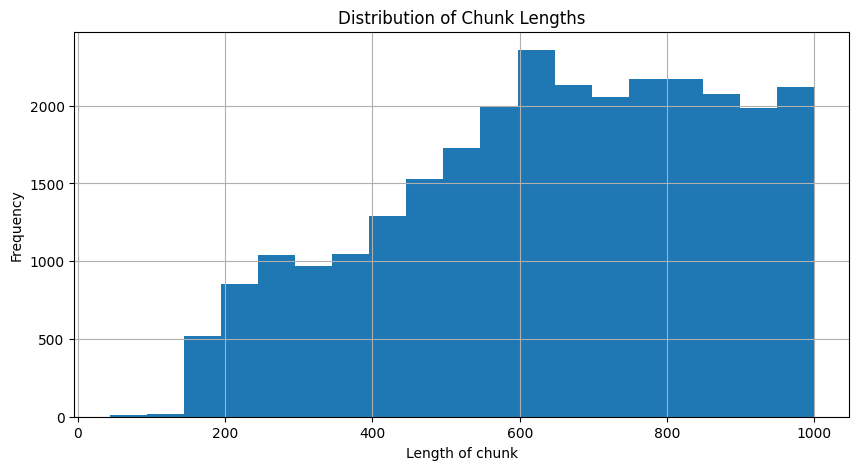

In [ ]:
chunked_df['chunk_length'].hist(bins = 19, figsize=(10, 5), grid = True)
plt.xlabel('Length of chunk')
plt.ylabel('Frequency')
plt.title('Distribution of Chunk Lengths')

In [ ]:
chunked_df[chunked_df['chunk_length'] < 100]

,unique_chunk_id,chunk_text,chunk_length,total_chunks,folder_path,file_name,year,month,language,type,title,text_id,chunk_id
10985,1398_00,## Impressionen\nBilder: ETH Zürich / Alessand...,59,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,together-2018.html,2018,9,de,internal,Together 2018,1398,00
11716,1548_00,#GewusstWie – Die Infrastruktur und die Tools ...,90,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,how-to-publish-your-research-data-in-the-resea...,2019,11,de,internal,How to publish your research data in the resea...,1548,00
12041,1659_00,Die ETH Zürich holt zusammen mit dem VSETH und...,97,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,gluehweihnachten-auf-dem-hoenggerberg.html,2016,12,de,internal,Gluehweihnachten auf dem hoenggerberg,1659,00
12061,1670_00,Näheres dazu finden Sie imFlyer Ihres Gebäudeb...,74,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,entsorgungswoche-2016.html,2016,10,de,internal,Entsorgungswoche 2016,1670,00
12113,1698_00,Geschlossen sind:\n(Grund: interne Veranstaltu...,81,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,abweichende-oeffnungszeiten-freitag-29-august....,2014,8,de,internal,Abweichende oeffnungszeiten freitag 29 august,1698,00
12223,1725_00,Der Zugriff ist online im Netzwerk der ETH Zür...,96,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,neue-zeitschriften-online.html,2014,7,de,internal,Neue zeitschriften online,1725,00
12266,1734_00,Der Zugriff ist online im Netzwerk der ETH Zür...,96,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,neue-zeitschriften.html,2014,4,de,internal,Neue zeitschriften,1734,00
12283,1737_00,Themen:\nWeitere Informationen und Anmeldung,43,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,tablets-fuer-studium-und-arbeit--betriebssyste...,2014,4,de,internal,Tablets fuer studium und arbeit betriebssystem...,1737,00
12285,1739_00,Die Schulung richtet sich an Fortgeschrittene....,90,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,ipad-fuer-studium-und-arbeit-.html,2014,4,de,internal,Ipad fuer studium und arbeit,1739,00
12359,1760_00,Die Veranstaltungen finden jeweils von 12.15 b...,65,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,keine-lust-auf-lange-schulungen.html,2014,10,de,internal,Keine lust auf lange schulungen,1760,00


In [ ]:
# save dataset
chunked_df.to_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'), index=False)

## 1.4 Loading of Benchmark Questions and Answers

Below we define the Benchmark questions and answers.

They were copied from the provided PDF-files. There was some difficulty with the formatting of certain letters that had to be adjusted manually.

Additionally we add the additional comments for the evaluation of answers. They will be used in part 3 of this project.

In [ ]:
Questions = """Who was president of ETH in 2003?
Who were the rectors of ETH between 2017 and 2022?
Who at ETH received ERC grants?
When did the InSight get to Mars?
What did Prof. Schubert say about ﬂying?
What is e-Sling?
Who are famous ETH alumni?
Who at ETH currently works on research regarding climate change?
How do alpine plants respond to climate change?
How would you make fertilizer without carbon emissions?
What research is ETH famous for?
How much of ETH’s electricity consumption is due to computing? How did that develop over the years?
What are pseudocereals and who does research on them?
Who is working on methods for targeted cancer treatment, and what do they use?
How is ETH research investigating methods to avoid diarrhea?
What is ETH Plus?
How do birds learn new songs?
What connections does ETH have to Hong Kong?
For how many years has ETH done research on Quantum Computing?
What are the current projections for the student numbers at ETH?
Why should I study at ETH?
Who investigated the catastrophic events in Tibet in 2016, and what was found?
Why should ETH receive any additional funding?
Anybody at ETH doing anything for people with disabilities?
Does ETH organize any competitions?""".split('\n')

In [ ]:
Answers = """Olaf Kübler
Sarah Springman, Günther Dissertori
European Research Council grants: Tobias Donner, Eliott Ash, Ursula Keller, Klaus Ensslin, Yiwen Chu, Judit Szuláovi, Sebastino Cantalupo, Veerle Sterken, Rachel Granoe, Paolo Crivelli, Christian Degen, Jonathan Home, Lavinia Heisenberg, Tilman Esslinger, …
26 November 2018
Flying is too cheap. If we want to reduce ﬂying, surcharges on air fares are certainly a step in the right direction.
4-seated electric airplane, built by 20 electrical and mechanical engineering students at ETH Zurich
Wilhelm Conrad Röntgen, Charles-Edouard Guillaume, Albert Einstein, Felix Bloch, Heinrich Rohrer, Georg Bednorz, Karl Alexander Müller, Alfred Werner, Fritz Haber, Richard Ernst, Tadeus Reichstein, Werner Arber, Othmar Ammann, Max Frisch, Rudolf Clausius, Santiago Calatrava, John von Neumann, Maurice Koechlin, Mileva Marić, Richard Kuhn, Albert Heim, Armand Borel, Ferdinand Piëch, Gabriel Narutowicz, Hansjörg Wyss, Kurt Wüthrich, Marcel Grossmann, Eduard Imhof.
ETH Department of Environmental Systems Science, D-USYS, on the research side. Anthony Patt (climate policy) and several researchers (check); Instute for Atmospheric and Climate Science; Chair of Hydrology and Water Resources Development, D-BAUG, NADEL on sustainable development (Jasmine Neve); ETH Net Zero on the institutional side.
Alpine plants are being signiﬁcantly impacted by climate change, primarily due to increasing temperatures that allow lower-elevation species to migrate upward. While many alpine plants can tolerate warming itself, they struggle to compete with faster-growing, larger plants from lower elevations, which are gaining a competitive edge in warmer conditions. This shiw is gradually altering the composition of plant communities, especially at mid-elevations where vegetation is already dense. Resistance from established alpine species and limited seed dispersal slow this process, but over time, as climate warming continues, lower-elevation plants are expected to establish themselves more widely. Experimental studies at ETH suggest that while some alpine plants can survive in future climatic conditions, many are at risk of being outcompeted, leading to signiﬁcant long-term changes in alpine ecosystems.
Reducing carbon emissions in fertilizer production requires shifting away from fossil fuel-based hydrogen and adopting more sustainable alternatives. One method is electrification using renewable energy, where hydrogen is produced via water electrolysis powered by solar or wind energy, eliminating direct emissions but requiring signiﬁcantly more energy. A third option is hydrogen production from biomass, which can be carbon-neutral if using waste materials but competes with food production for land and water. Additionally, improving fertilitier efficiency by reducing overuse and food waste can lower overall demand, while decentralitied production in regions with abundant renewables or biomass can enhance food security. A combination of these strategies, tailored to local conditions, offers the most effective path to decarbonizing fertilizer production, mitigating climate impact while maintaining agricultural productivity.
As a research-intensive university, ETH conducts research across a wide spectrum of disciplines. What are you interested in?
We have very little data on this. In 2017, computing at ETH Zurich produced 13,500 tons of CO2, which is about 10% of the total emissions produced. ETH Zurich consumes about 40 GWh of electricity per year; this number has been increasing over the years. ETH Zurich has the goal of Net-Zero emissions by 2030.
Pseudocereals are plants that are not botanically related to true cereals (such as wheat, rice, or corn) but are cultivated and used in a similar way. They produce storable seeds with grain-like characteristics, making them viable alternatives to traditional cereals. Pseudocereals oﬀer beneﬁts such as diﬀerent pest resistance, high nutritional value, and gluten-free properties. The three most important pseudocereals are buckwheat, quinoa, and amaranth. The Molecular Plant Breeding group at ETH Zurich is working on this.
Researchers across multiple disciplines are actively working on targeted cancer treatments, employing diverse approaches to enhance precision, efficacy, and safety. One group focuses on the development of tumor-targeted radioligands by refining synthetic methodologies. By leveraging solid-phase chemistry, they have created a modular system to construct folate-based radioconjugates. These compounds are designed to target tumors more effectively in radionuclide therapy, optimizing pharmacokinetics while ensuring stability and cost-effectiveness. Their efforts have led to the synthesis of structurally diverse folate conjugates, broadening the possibilities for radioligand-based treatments. Meanwhile, at ETH Zurich, biologist Daniel Richter and his colleagues have devised a method to improve the stability of drug-antibody linkages, ensuring that anti-cancer agents remain intact until they reach tumor cells. Their approach relies on a unique enzyme that modifies proteins in a highly specific manner, enabling the creation of stable and highly targeted antibody-drug conjugates. This innovation not only enhances drug efficacy but also reduces side effects by allowing higher dosages to be administered safely. Their research is laying the foundation for more precise cancer therapies that could significantly improve treatment outcomes. Another team, led by Professor Bernd Bodenmiller at the Tumor Profiler Center, is harnessing big data and precision medicine to personalize cancer treatment. By analyzing spatial images of tumor tissue at the molecular and cellular levels, researchers are generating extensive datasets that reveal unique tumor profiles. These data-driven insights help oncologists tailor therapies to individual patients, leading to more effective and personalized treatment plans. The integration of cutting-edge computational methods with clinical expertise is transforming cancer care, making it more adaptive to each patient's specific disease characteristics. Finally, researchers at Engimmune Therapeutics, an ETH Spin-Off company, are pioneering an approach that redirects immune cells to attack cancer more effectively. Their work focuses on engineering soluble T-cell receptors (TCRs), which recognize tumor-specific intracellular targets—an area previously inaccessible to traditional antibody therapies. By integrating machine learning and protein engineering, they can identify the most effective TCR variants, ensuring precise targeting while minimizing safety risks. Their technology not only enhances the immune system's ability to recognize and destroy cancer cells but also presents a scalable and cost-effective alternative to current immunotherapies.
At ETH Zurich, researchers are uncovering novel ways to combat bacterial intestinal diseases, focusing on how vaccinations can prevent diarrhea and hinder the spread of antibiotic resistance. Led by Senior Assistant Emma Slack, the team has demonstrated that vaccine-induced antibodies in the intestine play a crucial role in stopping bacterial infections before they cause illness. When bacteria such as Salmonella divide in the intestine, vaccine-induced IgA antibodies bind them together, effectively trapping entire bacterial families in clumps. This process, which occurs even at low bacterial densities, prevents the pathogens from attacking intestinal tissue. Instead of killing the bacteria outright—which could trigger an inflammatory immune response—the antibodies prevent their movement and accelerate their removal through excretion. The clumping also blocks genetic exchange between bacteria, a key factor in the spread of antibiotic resistance. The research team tested their approach using oral vaccines made from inactivated Salmonella and E. coli bacteria, and they believe the method could be extended to other harmful pathogens such as Shigella and Listeria. One promising application is in livestock, where antibiotic-resistant bacteria frequently originate. By vaccinating farm animals, the risk of human infections from contaminated meat or farm environments could be significantly reduced.
The expression can have two meanings. "Plus" can stand for Planning Landscape and Urban Settings, an initiative of ETH Zurich's Department of Civil, Environmental and Geomatic Engineering (D-BAUG). It can also mean ETH+, which is a program launched in 2017 by the Executive Board of ETH Zurich. It aims to ensure ETH Zurich retains its leading position into the future and to develop additional capabilities to take new, unconventional approaches in teaching, research as well as knowledge and technology transfer. In 2019, the program was renamed Open ETH.
Songbirds, such as zebra finches, learn new songs through a step-by-step process that mirrors how children acquire language. When exposed to a new song, the birds do not learn it all at once; instead, they adapt syllables they already know to resemble the new ones they must learn. Initially, the sequence of syllables may be jumbled, but in later phases, they rearrange them into the correct order. This incremental learning approach allows songbirds to expand their repertoire efficiently, minimizing effort while maximizing accuracy. Researchers at ETH Zurich have observed this pattern in controlled experiments, where young birds exposed to a changing song gradually modified their vocalizations in a structured way. Interestingly, this learning strategy is similar to methods used in computer linguistics for document comparison. Just as algorithms analyze the similarity between words while disregarding their order, birds modify individual syllables before organizing them properly. This suggests that songbirds have evolved a computationally efficient approach to learning, refining their songs in a way that minimizes cognitive load. Some researchers hypothesize that human infants might employ a similar method when learning new languages, adapting familiar sounds before integrating them into proper linguistic structures. However, further studies are needed to determine whether this minimalist strategy also applies to human language acquisition.
Besides having exchange of students and researchers, ETH Zurich maintains institutional agreements with o Chinese University of Hong Kong - Daegu Gyeongbuk Institute of Science and Technology - ETH Zurich, Joint Research Laboratory on Innovative Nanotechnology for Medicine and Healthcare o Chinese University of Hong Kong (CUHK), Chow Yuk Ho Technology Centre for Innovative Medicine (Multi-Scale Robotics Lab). o Hong Kong University of Science and Technology, Schools of Engineering & Science Recently, ETH Zurich and CUHK successfully performed a remote endoscopy.
ETH research on quantum electronics goes back to 1988. In 2021, ETH and Paul Scherrer Institute founded the Quantum Computing Hub.
In 2022, ETH Zurich was projecting an increase in student and doctoral student numbers of approximately 3.5% per year both for 2021–2024 and for 2025–2028.
ETH Zurich is one of the world's top universities, known for its outstanding education, pioneering research, and strong industry connections. With over 25,000 students from 120+ countries, ETH offers a diverse and inspiring academic environment. Its globally recognized programs, especially in science and engineering, are consistently ranked among the best. ETH has produced over 20 Nobel laureates, including Albert Einstein, and fosters innovation through industry collaborations and over 540 spin-offs. Located in Switzerland's thriving economy, ETH provides excellent career opportunities, while students also have the chance to immerse themselves in a multicultural setting and even learn German.
An international team of scientists from ETH Zurich, SLF/WSL, and the scientific commission GAPHAZ investigated the catastrophic glacier collapses in Tibet in 2016. Their research was based on satellite imagery from ESA's Sentinel satellites and radar data from TanDEM-X, a German Aerospace Center mission. The first collapse, which occurred on July 17 near Aru Co Lake, resulted in an ice avalanche of approximately 65 million cubic meters, causing the deaths of nine herders and numerous animals. Through data analysis, the researchers discovered that the glacier was in a "surging" state before its collapse, meaning that an excess ice mass had rapidly moved downstream, likely due to the accumulation of meltwater beneath the glacier. This lubrication weakened its base, ultimately leading to its catastrophic failure. Further analysis revealed that a neighboring glacier exhibited similar warning signs, prompting the scientists to issue an alert. On September 19, 2016, new satellite imagery showed large crevasses forming along this second glacier, mirroring the failure pattern of the first. Working with experts, including Yves Bühler (SLF) and Daniel Farinotti (VAW/WSL), the team modeled the risk of another collapse, leading SLF to produce a hazard indication map. The warning was swiftly communicated to Chinese scientists and local authorities, but only hours later, on September 22, the second glacier collapsed. Fortunately, this time there were no casualties. The investigation continues, with scientists examining geological, meteorological, and climate-related factors to understand why these rare twin glacier collapses occurred within such a short period. The event highlighted the potential role of climate change and demonstrated the growing capability of satellite-based early warning systems.
Additional funding for ETH Zurich is not just an investment in one institution - it’s an investment in innovation, education, and the future. It enables transformative researchnurtures global talent, and drives economic and societal progress, all of which have lasting beneﬁts locally, nationally, and internationally.
ETH Zurich's goal is to minimize obstacles as much as possible or ideally eliminate them completely, as spelled out in the goal of the central initiative Barrier-Free ETH: the university should be designed according to the principle of “Design for all” so that all people have largely unrestricted access to the buildings and services. In addition, there are various research projects connected to assistive technology.
ETH Zurich organizes a number of competitions for the public good, addressing youth, aspiring researchers, sports, innovators, and entrepreneurs. What area would you like to explore?""".split('\n')

In [ ]:
print("Num. Questions:", len(Questions))
print("Num. Answers:", len(Answers))

Num. Questions: 25
Num. Answers: 25


In [ ]:
for question, answer in zip(Questions, Answers):
  print(f"Q: {question}\nA: {answer}")

Q: Who was president of ETH in 2003?
A: Olaf Kübler
Q: Who were the rectors of ETH between 2017 and 2022?
A: Sarah Springman, Günther Dissertori
Q: Who at ETH received ERC grants?
A: European Research Council grants: Tobias Donner, Eliott Ash, Ursula Keller, Klaus Ensslin, Yiwen Chu, Judit Szuláovi, Sebastino Cantalupo, Veerle Sterken, Rachel Granoe, Paolo Crivelli, Christian Degen, Jonathan Home, Lavinia Heisenberg, Tilman Esslinger, …
Q: When did the InSight get to Mars?
A: 26 November 2018
Q: What did Prof. Schubert say about ﬂying?
A: Flying is too cheap. If we want to reduce ﬂying, surcharges on air fares are certainly a step in the right direction.
Q: What is e-Sling?
A: 4-seated electric airplane, built by 20 electrical and mechanical engineering students at ETH Zurich
Q: Who are famous ETH alumni?
A: Wilhelm Conrad Röntgen, Charles-Edouard Guillaume, Albert Einstein, Felix Bloch, Heinrich Rohrer, Georg Bednorz, Karl Alexander Müller, Alfred Werner, Fritz Haber, Richard Ernst, T

In [ ]:
# Initialize an empty dictionary to hold the final structure
Q_A_ground_thruth_relevancy_dict = {}

# Iterate and populate the dictionary
# - enumerate(..., start=1) creates the IDs from 1, 2, 3...
# - zip() pairs each question with its corresponding answer
for q_id, (question, answer) in enumerate(zip(Questions, Answers), start=1):
    Q_A_ground_thruth_relevancy_dict[q_id] = {
        "question": question,
        "answer": answer,
        "possible_relevant_chunks": set(),  # empty set for possible rel. chunks (wide selection)
        "ground_truth_relevance": {},  # save scores with chunk_id as key
        "evaluation_comments": ""  # define as empty string (will be set only for some questions)
    }

In [ ]:
# Set the comments for some questions
Q_A_ground_thruth_relevancy_dict[3]["evaluation_comments"] = """The criterion here: does it come up with a list that spans multiple years and departments? Score is +1 for every actual recipient of an ERC grant, –1 for non-recipients or people not at ETH. Points are
Points = 1 – exp(–Score/5), or 0 if Score<0
Alternatively, and preferred: “ETH Zurich received hundreds of ERC grants over the years. What year or discipline are you interested in?”: 1 point"""
Q_A_ground_thruth_relevancy_dict[7]["evaluation_comments"] = """“Famous” is ambiguous.
Score: +1 for people from above list; +0.5 for unlisted people who are indeed alumni; –1 for people who are not alumni of ETH
Points = 1 – exp(–Score/5), or 0 if Score<0"""
Q_A_ground_thruth_relevancy_dict[8]["evaluation_comments"] = """Answer should point out that there are several initiatives on the research, policy and institutional sides."""
Q_A_ground_thruth_relevancy_dict[9]["evaluation_comments"] = """This is about explaining a phenomenon based on ETH research."""
Q_A_ground_thruth_relevancy_dict[10]["evaluation_comments"] = """This is about explaining a phenomenon based on ETH research."""
Q_A_ground_thruth_relevancy_dict[11]["evaluation_comments"] = """As an official bot, it should not favor one department over another. When questions about being currently famous or successful arise, they need to be deﬂected."""
Q_A_ground_thruth_relevancy_dict[12]["evaluation_comments"] = """It is important to say, “we do not know,” but go out and ﬁnd related informaZon."""
Q_A_ground_thruth_relevancy_dict[13]["evaluation_comments"] = """This is about explaining a phenomenon based on ETH research."""
Q_A_ground_thruth_relevancy_dict[14]["evaluation_comments"] = """This is about collecting, summarizing, and explaining a phenomenon based on ETH research."""
Q_A_ground_thruth_relevancy_dict[15]["evaluation_comments"] = """This is about explaining a phenomenon based on ETH research."""
Q_A_ground_thruth_relevancy_dict[16]["evaluation_comments"] = """This is about dealing with multiple meanings of the same term."""
Q_A_ground_thruth_relevancy_dict[17]["evaluation_comments"] = """This is about explaining a phenomenon based on ETH research."""
Q_A_ground_thruth_relevancy_dict[22]["evaluation_comments"] = """This is about explaining a phenomenon based on ETH research."""
Q_A_ground_thruth_relevancy_dict[23]["evaluation_comments"] = """Do not get specific or compare to other universities; deﬂect to higher education in general, similar to question about “most famous”."""
Q_A_ground_thruth_relevancy_dict[25]["evaluation_comments"] = """Do not foster "competitions" of competitions. Arguably, a very famous one is the CYBATHLON, which could be mentioned if the user asks more speciﬁcally, for example in the context of question 24."""

In [ ]:
# Print the result
pprint.pprint(Q_A_ground_thruth_relevancy_dict)

{1: {'answer': 'Olaf Kübler',
     'evaluation_comments': '',
     'ground_truth_relevance': {},
     'possible_relevant_chunks': set(),
     'question': 'Who was president of ETH in 2003?'},
 2: {'answer': 'Sarah Springman, Günther Dissertori',
     'evaluation_comments': '',
     'ground_truth_relevance': {},
     'possible_relevant_chunks': set(),
     'question': 'Who were the rectors of ETH between 2017 and 2022?'},
 3: {'answer': 'European Research Council grants: Tobias Donner, Eliott Ash, '
               'Ursula Keller, Klaus Ensslin, Yiwen Chu, Judit Szuláovi, '
               'Sebastino Cantalupo, Veerle Sterken, Rachel Granoe, Paolo '
               'Crivelli, Christian Degen, Jonathan Home, Lavinia Heisenberg, '
               'Tilman Esslinger, …',
     'evaluation_comments': 'The criterion here: does it come up with a list '
                            'that spans multiple years and departments? Score '
                            'is +1 for every actual recipient of an 

We prepared the question and answers in a dictionary ready for the following steps.

We will save it as pickle file to maintain the structure of it.

In [ ]:
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-03-questions-answers.pkl'), 'wb') as f:
    pickle.dump(Q_A_ground_thruth_relevancy_dict, f)

## 1.5 Determination of chunk relevance for question answering

### Preselection of possible relevant chunks

In [8]:
# Load dataset
chunked_df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [ ]:
# Load Q_A_data
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-03-questions-answers.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In this section we will determine the ground-truth relevancy for the chunks for each questions.
The scoring is done accordingly to the project requirements:

>  Assign numerical scores to generate ground-truth relevance labels to evaluate retrieval quality:<br>
>  fully answers → 1.0, partially answers → 0.5, not relevant → 0.0

Due to the number of chunks (approx. 28'000) and the 25 questions, sending each combination to an LLM would result in 700'000 calls to the LLM. Since most of the chunks are clearly not relevant for most questions we will do a pre-selection using sentence-similarity and also using question-specific text-search in the text of the chunks.

Chunks not meeting this pre-selection will be assigned a score of 0.0 and the pre-selected chunks (on a question basis) will be sent to an LLM do determine the relevancy score.

Definition of search terms:


In [ ]:
# Define question-specific search terms. The key is the question ID (starting from 1).
# An empty list means no specific text search will be performed for that question.
search_terms_by_question = {
    1: ["Olaf Kübler ", "Kübler Olaf"],
    2: ["Springman", "Dissertori"],
    3: ["Europäische Forschungsrat", "European Research Council"],
    4: ["InSight", "Mars"],
    5: ["Schubert"],
    6: ["Sling"],
    7: ["Röntgen", "Charles-Edouard Guillaume", "Guillaume Charles-Edouard",
        "Albert Einstein", "Einstein Albert", "Felix Bloch", "Bloch Felix",
        "Heinrich Rohrer", "Rohrer Heinrich", "Bednorz",
        "Karl Alexander Müller", "Müller Karl Alexander",
        "Alfred Werner", "Werner Alfred", "Fritz Haber", "Haber Fritz",
        "Richard Ernst", "Ernst Richard", "Tadeus Reichstein", "Reichstein Tadeus",
        "Werner Arber", "Arber Werner", "Othmar Ammann", "Ammann Othmar",
        "Max Frisch", "Frisch Max", "Rudolf Clausius", "Clausius Rudolf",
        "Calatrava", "von Neumann", "Maurice Koechlin", "Koechlin Maurice", "Maurice Köchlin", "Köchlin Maurice",
        "Mileva Marić", "Marić Mileva", "Richard Kuhn", "Kuhn Richard",
        "Albert Heim", "Heim Albert", "Armand Borel", "Borel Armand",
        "Ferdinand Piëch", "Piëch Ferdinand", "Narutowicz",
        "Hansjörg Wyss", "Wyss Hansjörg", "Kurt Wüthrich", "Wüthrich Kurt",
        "Marcel Grossmann", "Grossmann Marcel", "Eduard Imhof", "Imhof Eduard"],
    8: ["climate change", "Klimawandel"],
    9: ["alpine plants", "alpine Pflanzen"],
    10: ["fertilizer", "Dünger"],
    11: [],
    12: ["electricity consumption", "Stromverbrauch"],
    13: ["pseudocereals", "Pseudogetreide"],
    14: ["cancer", "Krebs-Forschung", "Krebs Forschung"],
    15: ["diarrhea", "Durchfall", "Verdauung"],
    16: ["ETH Plus", "D-BAUG", "Open ETH", "offene ETH"],
    17: ["bird", "Vogel", "Vögel"],
    18: ["Hong Kong", "China"],
    19: ["quantum", "Quanten"],
    20: ["student number", "Studierendenwachstum"],
    21: [],
    22: ["Tibet"],
    23: ["funding", "Fördergelder"],
    24: ["disabilities", "barrierefrei"],
    25: ["CYBATHLON"]}

In [ ]:
# Setup for similarity search
# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define the file path for your cached embeddings
embeddings_file = os.path.join(base_folder, 'Stage2/Working-dir/Stage2-04-preselection-embeddings.npy')

if os.path.exists(embeddings_file):
    print("Loading cached embeddings from file...")
    chunk_embeddings = np.load(embeddings_file)
else:
    print("No cached file found. Generating embeddings...")
    # This is the slow part that will now run only once
    chunk_embeddings = model.encode(
        chunked_df['chunk_text'].tolist(),
        batch_size=128,
        show_progress_bar=True
    )
    print("Saving embeddings to cache file...")
    np.save(embeddings_file, chunk_embeddings)

print(f"Embeddings loaded successfully. Shape: {chunk_embeddings.shape}")

# The dimension of the embeddings
d = chunk_embeddings.shape[1]

# Create a FAISS index
# Since normalized embeddings -> maximizing the Inner Product is equivalent to maximizing Cosine Similarity.
index = faiss.IndexFlatIP(d)

# Add the chunk embeddings to the index
index.add(np.array(chunk_embeddings, dtype=np.float32))

print(f"FAISS index created with {index.ntotal} vectors.")

Loading cached embeddings from file...
Embeddings loaded successfully. Shape: (28072, 384)
FAISS index created with 28072 vectors.


In [ ]:
# Create a mapping from the FAISS index position back to original chunk_id
chunk_ids = chunked_df['unique_chunk_id'].tolist()
index_to_chunk_id = {i: chunk_ids[i] for i in range(len(chunk_ids))}
chunk_id_to_index = {chunk_id: i for i, chunk_id in enumerate(chunk_ids)}

In [ ]:
# Verify the mapping works correctly
print("Verifying index mapping...")
sample_idx = 0
chunk_id = index_to_chunk_id[sample_idx]
corresponding_text = chunked_df[chunked_df['unique_chunk_id'] == chunk_id]['chunk_text'].iloc[0]
print(f"Index {sample_idx} -> Chunk ID {chunk_id}")
print(f"Text preview: {corresponding_text[:100]}...")

Verifying index mapping...
Index 0 -> Chunk ID 0000_00
Text preview: Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusamm...


In [ ]:
# Setup of the search functions
#  Text Search
def find_chunks_by_text_search(search_terms: list[str], all_chunks_df: pd.DataFrame) -> set[str]:
    """
    Finds chunks that contain any of the specified search terms.

    Args:
        search_terms: A list of strings to search for.
        all_chunks_df: A DataFrame with 'unique_chunk_id' and 'chunk_text' columns.

    Returns:
        A set of chunk_ids that contain at least one of the search terms.
    """
    if not search_terms:
        return set()

    matching_chunks = set()
    for term in search_terms:
        matching_chunks.update(all_chunks_df[all_chunks_df['chunk_text'].str.contains(
            term, case=False, na=False)]['unique_chunk_id'])
    return matching_chunks

# Similarity Search
def find_chunks_by_similarity(
    question: str,
    answer: str,
    sbert_model: SentenceTransformer,
    faiss_index: faiss.Index,
    idx_to_id_map: dict,
    k: int = 1000
) -> set[str]:
    """
    Finds the top-k most similar chunks to a given question-answer pair.

    Args:
        question: The question string.
        answer: The answer string.
        sbert_model: The pre-loaded SentenceTransformer model.
        faiss_index: The pre-built FAISS index of all chunk embeddings.
        idx_to_id_map: A mapping from FAISS index position to chunk_id.
        k: The number of most similar chunks to retrieve.

    Returns:
        A set of the top-k most similar chunk_ids.
    """
    # Combine question and answer for a richer query embedding
    query_text = f"{question} \n {answer}"

    # Generate the embedding for the query
    query_embedding = sbert_model.encode([query_text])

    # Ensure k is not larger than the total number of items in the index
    k = min(k, faiss_index.ntotal)

    # Search the FAISS index for the k nearest neighbors
    # The search returns distances (D) and indices (I) of the neighbors
    _, indices = faiss_index.search(np.array(query_embedding, dtype=np.float32), k)

    # Get the indices of the results (it's a 2D array, so we take the first row)
    result_indices = indices[0]

    # Map the FAISS indices back to the original chunk_ids
    similar_chunk_ids = {idx_to_id_map[i] for i in result_indices}

    return similar_chunk_ids


In [ ]:
# Iterate through the questions and apply the functions
for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
    question = data["question"]
    answer = data["answer"]

    print(f"\nProcessing Q{q_id}: {question}")
    # 1. Perform text search
    # Get the search terms for the current question; default to an empty list if not defined
    specific_search_terms = search_terms_by_question.get(q_id, [])
    text_search_results = find_chunks_by_text_search(specific_search_terms, chunked_df)
    print(f"  Found {len(text_search_results)} chunks via text search: {text_search_results}")

    # 2. Perform similarity search
    # We search for the top 500 using question and answer combined
    similarity_search_results = find_chunks_by_similarity(question, answer, model, index, index_to_chunk_id, k=500)
    # Append the results by searching only using the question (top 500)
    similarity_search_results = similarity_search_results.union(
        find_chunks_by_similarity(question, "", model, index, index_to_chunk_id, k=500))
    print(f"  Found {len(similarity_search_results)} chunks via similarity search: {similarity_search_results}")

    # 3. Combine the results
    # The union of sets automatically handles duplicates
    combined_chunk_ids = text_search_results.union(similarity_search_results)

    # 4. Store the combined set of chunk_ids in the main dictionary
    Q_A_ground_thruth_relevancy_dict[q_id]["possible_relevant_chunks"] = combined_chunk_ids
    print(f"  Stored a combined total of {len(combined_chunk_ids)} unique potential chunks for Q{q_id}.")


Processing Q1: Who was president of ETH in 2003?
  Found 1 chunks via text search: {'0285_08'}
  Found 642 chunks via similarity search: {'3426_04', '0003_07', '3820_04', '2773_13', '2993_04', '2887_02', '2723_07', '3330_00', '2906_05', '2976_00', '3855_00', '2884_00', '3052_01', '2891_03', '3753_02', '3649_05', '3409_04', '2813_00', '2766_02', '2741_00', '2803_03', '4167_03', '3044_05', '3204_01', '3079_01', '2424_01', '3877_00', '3590_00', '2603_02', '2397_03', '3330_06', '3318_02', '2692_01', '2620_01', '2750_01', '2323_02', '3033_09', '4301_01', '2959_01', '2857_12', '2282_04', '3871_06', '3523_00', '3774_03', '2597_01', '2358_03', '2893_06', '3205_00', '2856_15', '3036_02', '4046_05', '3837_04', '4038_09', '2491_01', '2867_01', '2967_08', '3710_01', '2995_06', '1771_02', '2355_16', '3021_09', '3421_00', '3138_02', '2692_02', '4064_08', '2428_00', '3243_06', '4167_02', '3429_08', '2684_00', '3318_01', '2550_01', '3185_01', '0769_01', '3013_10', '3022_06', '3600_16', '4169_08', '29

In [ ]:
# Iterate through dictionary to get total number of potential chunks
total_chunks = 0
for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
    total_chunks += len(data["possible_relevant_chunks"])

print("Total potential chunks", total_chunks)

Total potential chunks 20876


We receive a bit more than 20'000 combinations of questions and associated possible relevant chunks. This is a number of calls to an LLM that is reasonable.

In [ ]:
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-05-q-a-with-possible-rel-chunks.pkl'), 'wb') as f:
    pickle.dump(Q_A_ground_thruth_relevancy_dict, f)

### Assigning Ground-Truth chunk relevance scores

In [ ]:
# Load Q_A_data
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-05-q-a-with-possible-rel-chunks.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In [ ]:
# Load dataset
chunked_df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

Below we set our API key. We will be using [Groq](https://groq.com/) to use open-source models for a reasonable price.

In [ ]:
#  SET API KEY
from google.colab import userdata
api_key = userdata.get('GROQ_API_KEY')

Below we define a class based on Pydantic `BaseModel` for fixing the expected results we get from the chain. Additionally we define an LLM, we use [Llama 4 Scout (16 Experts of 17B parameters](https://huggingface.co/meta-llama/Llama-4-Scout-17B-16E-Instruct)), the prompt and the chain.



In [ ]:
# 1. Define the desired output structure using Pydantic
class RelevanceEvaluation(BaseModel):
    """
    Evaluates if a paragraph provides a relevant answer to a given question.
    """
    reasoning: str = Field(
        description="A brief explanation for the assigned relevance_score, referencing the question and paragraph content."
    )
    relevance_score: float = Field(
        description="The relevance score: 1.0 for a full answer, 0.5 for a partial answer, 0.0 for no relevance."
    )

# 2. Configure the Language Model
# Using a powerful model for better nuanced evaluation.
llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0,
    max_tokens=512,
    api_key=api_key
)

# Create a structured LLM that will format the output into the Pydantic model
structured_llm = llm.with_structured_output(
    RelevanceEvaluation,
    method="json_mode",
    include_raw=False
)

# 3. Create the Prompt Template
# This prompt is engineered to guide the LLM in its evaluation task.
prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a highly intelligent and precise evaluator for a benchmark Q&A dataset.
Your task is to assess whether a provided paragraph contains information that answers a given question.
You must assign a numerical score based on these strict criteria:
1.0: The paragraph directly and completely answers the question.
0.5: The paragraph provides some relevant information but does not fully answer the question. It might be missing key details, be too general, or only answer a sub-part of the question.
0.0: The paragraph does not contain any information relevant to answering the question.

Respond ONLY in a JSON format with two fields: 'reasoning' and 'relevance_score'.
"""),
    ("user", "Evaluate the following pair:\n\nQuestion: '{question}'\n\nParagraph: '{paragraph}'")
])

# 4. Create the final evaluation chain
chain = prompt | structured_llm

#### Evaluation of sample questions and paragraphs

Below we define a function and evaluate some example questions with paragraphs.

In [ ]:
async def evaluate_relevance_batch_async(fixed_question: str, chunks_to_evaluate: List[Dict]) -> List[dict]:
    """
    Processes a list of chunks against a fixed question and returns evaluations
    with a correct, flat dictionary structure.
    """
    if not chunks_to_evaluate:
        return []

    print(f"Processing {len(chunks_to_evaluate)} chunks against the question: '{fixed_question}'...")

    # Prepare batch inputs: map 'chunk_text' to the 'paragraph' key expected by the prompt.
    batch_inputs = [{"question": fixed_question, "paragraph": chunk["chunk_text"]} for chunk in chunks_to_evaluate]

    try:
        results_or_errors = await chain.abatch(
            batch_inputs,
            config=RunnableConfig(max_concurrency=5, return_exceptions=True)
        )

        processed_results = []
        for i, res_or_err in enumerate(results_or_errors):
            original_chunk = chunks_to_evaluate[i]

            base_result = {
                "question": fixed_question,
                "unique_chunk_id": original_chunk["unique_chunk_id"],
                "chunk_text": original_chunk["chunk_text"],
                "index": i
            }

            if isinstance(res_or_err, RelevanceEvaluation):
                base_result.update({
                    "relevance_score": res_or_err.relevance_score,
                    "reasoning": res_or_err.reasoning,
                    "status": "success"
                })
            elif isinstance(res_or_err, Exception):
                base_result.update({
                    "relevance_score": None,
                    "reasoning": f"Failed to process: {res_or_err}",
                    "status": "error"
                })
            processed_results.append(base_result)
        return processed_results

    except Exception as e:
        # Handle critical batch failures
        print(f"A critical error occurred during batch processing: {e}")
        return [{
            "question": fixed_question,
            "unique_chunk_id": chunk["unique_chunk_id"],
            "chunk_text": chunk["chunk_text"],
            "relevance_score": None,
            "reasoning": f"Batch processing failed: {e}",
            "index": i,
            "status": "error_batch_failed"
        } for i, chunk in enumerate(chunks_to_evaluate)]


In [ ]:
# --- Define your fixed question and list of data chunks here ---
fixed_question = "What are the primary colors in additive color models?"

# The input is now a list of dictionaries, each with a unique ID and the text content.
chunks_to_evaluate = [
    {
        "unique_chunk_id": "docA_chunk_001",
        "chunk_text": "In additive color models, such as RGB used in screens and lighting, the primary colors are red, green, and blue. When combined in various proportions, they can produce a wide spectrum of other colors, including white when all three are mixed at full intensity."
    },
    {
        "unique_chunk_id": "docB_chunk_007",
        "chunk_text": "Subtractive color models, like CMYK used in printing, start with white and subtract colors. The primaries here are cyan, magenta, and yellow. Black (K) is often added for depth."
    },
    {
        "unique_chunk_id": "docA_chunk_002",
        "chunk_text": "Color theory is a complex field involving physics and psychology. Additive colors mix light, while subtractive colors absorb light. Red and blue are often considered important colors."
    }
]

# Run the asynchronous evaluation function
evaluation_results = await evaluate_relevance_batch_async(fixed_question, chunks_to_evaluate)

print("\n--- Evaluation Results ---")
if evaluation_results:
    for result in evaluation_results:
        print(json.dumps(result, indent=2))

Processing 3 chunks against the question: 'What are the primary colors in additive color models?'...
A critical error occurred during batch processing: name 'chain' is not defined

--- Evaluation Results ---
{
  "question": "What are the primary colors in additive color models?",
  "unique_chunk_id": "docA_chunk_001",
  "chunk_text": "In additive color models, such as RGB used in screens and lighting, the primary colors are red, green, and blue. When combined in various proportions, they can produce a wide spectrum of other colors, including white when all three are mixed at full intensity.",
  "relevance_score": null,
  "reasoning": "Batch processing failed: name 'chain' is not defined",
  "index": 0,
  "status": "error_batch_failed"
}
{
  "question": "What are the primary colors in additive color models?",
  "unique_chunk_id": "docB_chunk_007",
  "chunk_text": "Subtractive color models, like CMYK used in printing, start with white and subtract colors. The primaries here are cyan, mag

#### Running Evaluation on news article chunks

We will save the evaluation after a file to save the progress in case of disconnection with the runtime.

In [ ]:
# with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-06-q-a-temp-file.pkl'), 'wb') as f:
#     pickle.dump(Q_A_ground_thruth_relevancy_dict, f)

For the evaluation of the relevancy of a paragraph we will put together the publication time of the article and the article itself. The text date is needed to evaluate some of the question.

In [ ]:
# Function to return the month as text from the number
def get_month_name(month_number):
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    return months[month_number - 1]

In [ ]:
# As an example
chunk_id = "2101_01"
text_to_check = "Published in: " + get_month_name(
        chunked_df[chunked_df['unique_chunk_id']==chunk_id]['month'].item()) + " " +\
        str(chunked_df[chunked_df['unique_chunk_id']==chunk_id]['year'].item()) + "\n" +\
        "Text: " + "\n" + chunked_df[chunked_df['unique_chunk_id']==chunk_id]['chunk_text'].item()
pprint.pprint(text_to_check)

('Published in: September 2022\n'
 'Text: \n'
 '## Ausstellungseröffnung im kommenden Jahr\n'
 'Aufgrund der Standortverlegung bleibt die Dauerausstellung von Thomas Manns '
 'Arbeitszimmer und seiner privaten Bibliothek vorübergehend geschlossen. Am '
 '28. Februar 2023 werden eine neugestaltete Dauerausstellung sowie die '
 'Sonderausstellung «Thomas Mann. Achtung Europa!» im Hauptgebäude eröffnet.')


In [ ]:
# Test it on some paragraphs for the first question
fixed_question = Q_A_ground_thruth_relevancy_dict[1]["question"]
# Get 30 random elements from possible chunks set
chunks_ids_to_evaluate = list(Q_A_ground_thruth_relevancy_dict[1]["possible_relevant_chunks"])[0:30]
chunks_to_evaluate = []
for chunk_id in chunks_ids_to_evaluate:
    text_to_check = "Published in: " + get_month_name(
        chunked_df[chunked_df['unique_chunk_id']==chunk_id]['month'].item()) + " " +\
        str(chunked_df[chunked_df['unique_chunk_id']==chunk_id]['year'].item()) + "\n" +\
        "Text: " + "\n" + chunked_df[chunked_df['unique_chunk_id']==chunk_id]['chunk_text'].item()
    chunks_to_evaluate.append({'unique_chunk_id': chunk_id,
                               'chunk_text': text_to_check})
evaluation_results = await evaluate_relevance_batch_async(fixed_question, chunks_to_evaluate)
print("\n--- Evaluation Results ---")
if evaluation_results:
    for result in evaluation_results:
        pprint.pprint(result)

Processing 30 chunks against the question: 'Who was president of ETH in 2003?'...

--- Evaluation Results ---
{'chunk_text': 'Published in: May 2017\n'
               'Text: \n'
               'At its meeting of 17 May 2017, the ETH Board appointed 15 new '
               'professors upon application of ETH Zurich President Lino '
               'Guzzella. The Board also acknowledged the resignation of one '
               'professor, thanking him for his service.',
 'index': 0,
 'question': 'Who was president of ETH in 2003?',
 'reasoning': 'The paragraph does not provide information about who was '
              'president of ETH in 2003. It mentions ETH Zurich President Lino '
              'Guzzella but does not specify the year he became president or '
              'if he was president in 2003.',
 'relevance_score': 0.0,
 'status': 'success',
 'unique_chunk_id': '3600_00'}
{'chunk_text': 'Published in: December 2020\n'
               'Text: \n'
               '## rETHink takes sh

In [ ]:
import time
# Load Q_A_data temp file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-06-q-a-temp-file.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

explanations_dict = {}

for j in range(1,26):
  print(f"Processing Q{j}")
  # if ground_truth_relevance is an not an empty dict (has values) -> continue
  if Q_A_ground_thruth_relevancy_dict[j]["ground_truth_relevance"]:
    print("Question", j, " was already evaluated.")
    continue
  fixed_question = Q_A_ground_thruth_relevancy_dict[j]["question"]
  chunks_ids_to_evaluate = Q_A_ground_thruth_relevancy_dict[j]["possible_relevant_chunks"]
  chunks_to_evaluate = []
  for chunk_id in chunks_ids_to_evaluate:
    text_to_check = "Published in: " + get_month_name(
        chunked_df[chunked_df['unique_chunk_id']==chunk_id]['month'].item()) + " " +\
        str(chunked_df[chunked_df['unique_chunk_id']==chunk_id]['year'].item()) + "\n" +\
        "Text: " + "\n" + chunked_df[chunked_df['unique_chunk_id']==chunk_id]['chunk_text'].item()
    chunks_to_evaluate.append({'unique_chunk_id': chunk_id,
                               'chunk_text': text_to_check})
    # Add -1 as the value in the relevance_score before processing (check for completeness later)
    Q_A_ground_thruth_relevancy_dict[j]["ground_truth_relevance"][chunk_id] = -1

  # Evaluate the question
  evaluation_results = await evaluate_relevance_batch_async(fixed_question, chunks_to_evaluate)
  explanations_dict[j] = evaluation_results

  # Store the results from the successful evaluations
  for result in evaluation_results:
    # Check if the evaluation was successful AND the necessary key exists
    if result.get("status") == "success" and "unique_chunk_id" in result:
      chunk_id = result["unique_chunk_id"]
      score = result.get("relevance_score")

      # Assign the score to your dictionary
      Q_A_ground_thruth_relevancy_dict[j]["ground_truth_relevance"][chunk_id] = score

    else:
      # Print any failed or malformed results for debugging
      print("\n⚠️ Skipping a failed or malformed result:")
      pprint.pprint(result)

  # Wait 10 seconds
  time.sleep(10)
  # save the dictionary as a file to keep the progress
  with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-06-q-a-temp-file.pkl'), 'wb') as f:
    pickle.dump(Q_A_ground_thruth_relevancy_dict, f)

Processing Q1
Question 1  was already evaluated.
Processing Q2
Question 2  was already evaluated.
Processing Q3
Processing 665 chunks against the question: 'Who at ETH received ERC grants?'...
Processing Q4
Processing 914 chunks against the question: 'When did the InSight get to Mars?'...
Processing Q5
Processing 950 chunks against the question: 'What did Prof. Schubert say about ﬂying?'...
Processing Q6
Processing 978 chunks against the question: 'What is e-Sling?'...
Processing Q7
Processing 824 chunks against the question: 'Who are famous ETH alumni?'...
Processing Q8
Processing 1164 chunks against the question: 'Who at ETH currently works on research regarding climate change?'...
Processing Q9
Processing 603 chunks against the question: 'How do alpine plants respond to climate change?'...
Processing Q10
Processing 760 chunks against the question: 'How would you make fertilizer without carbon emissions?'...
Processing Q11
Processing 621 chunks against the question: 'What research is

Running all the evaluations took about 45 minutes. The calls to the LLM are close to the allowed limits both for requests and number of input tokens.

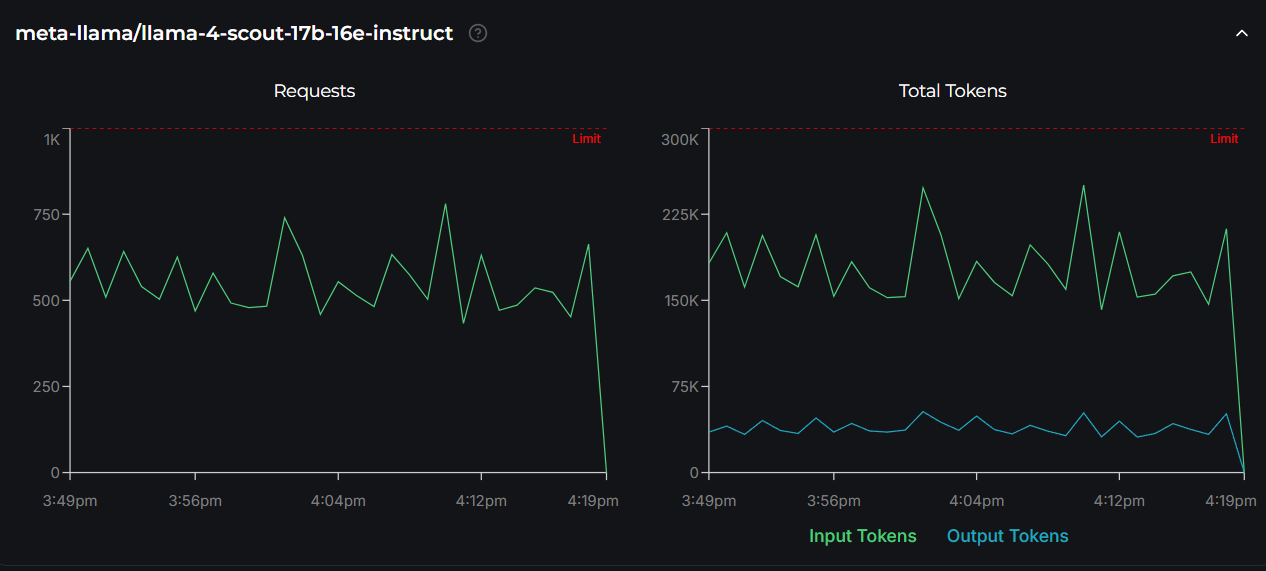

In [ ]:
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-06-q-a-temp-file.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In [ ]:
# Check all combinations of questions and relevant chunks
# Check if any have a score different from 0, 0.5, 1
for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
  print(f"Processing Q{q_id}")
  sum = 0
  for chunk_id, score in data["ground_truth_relevance"].items():
    if score not in [0, 0.5, 1]:
      print("Score different from 0, 0.5, 1.0")
      print("Question:", q_id, "chunk_id:", chunk_id, "Score:", score)
    else:
      sum += score
  print("Sum of scores:", sum)

Processing Q1
Sum of scores: 22.5
Processing Q2
Sum of scores: 87.5
Processing Q3
Sum of scores: 68.0
Processing Q4
Sum of scores: 26.0
Processing Q5
Sum of scores: 4.5
Processing Q6
Sum of scores: 3.0
Processing Q7
Sum of scores: 78.5
Processing Q8
Sum of scores: 211.5
Processing Q9
Sum of scores: 37.5
Processing Q10
Sum of scores: 61.5
Processing Q11
Sum of scores: 158.0
Processing Q12
Sum of scores: 1.0
Processing Q13
Sum of scores: 9.5
Processing Q14
Sum of scores: 219.5
Processing Q15
Sum of scores: 44.0
Processing Q16
Sum of scores: 9.0
Processing Q17
Sum of scores: 0.0
Processing Q18
Sum of scores: 12.0
Processing Q19
Sum of scores: 22.5
Processing Q20
Sum of scores: 32.0
Processing Q21
Sum of scores: 194.5
Processing Q22
Sum of scores: 6.5
Processing Q23
Sum of scores: 171.0
Processing Q24
Sum of scores: 90.0
Processing Q25
Sum of scores: 90.5


All the scores have a value of 0, 0.5 or 1.

Upon investigating the sum of all scores there is quite a difference between questions. Looking through them most of it makes sense. Open questions like question 21 "Why should I study at ETH" have a high sum of scores since many chunks could help in partially answering that question.

Question 21 "How much of ETH's electricity consumption is due to computing? How did that develop over the years?" has a sum of scores of 1.0, which is reasonable, since it is a very specific question.

Question 17 "How do birds learn new songs?" has zero score (no relevant paragraphs). It might be that such an article is missing from the original data or that the preselection didn't capture the relevant documents.


#### Additional evaluation for question 17

In [ ]:
# Load Q_A_data temp file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-06-q-a-temp-file.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

explanations_dict = {}
j = 17

print(f"Processing Q{j}")
# if ground_truth_relevance is an not an empty dict (has values) -> continue
fixed_question = Q_A_ground_thruth_relevancy_dict[j]["question"]

# evaluate all chunks for this question
chunks_ids_to_evaluate = chunked_df["unique_chunk_id"].unique().tolist()
chunks_to_evaluate = []
for chunk_id in chunks_ids_to_evaluate:
  text_to_check = "Published in: " + get_month_name(
      chunked_df[chunked_df['unique_chunk_id']==chunk_id]['month'].item()) + " " +\
      str(chunked_df[chunked_df['unique_chunk_id']==chunk_id]['year'].item()) + "\n" +\
      "Text: " + "\n" + chunked_df[chunked_df['unique_chunk_id']==chunk_id]['chunk_text'].item()
  chunks_to_evaluate.append({'unique_chunk_id': chunk_id,
                            'chunk_text': text_to_check})
  # Add -1 as the value in the relevance_score before processing (check for completeness later)
  Q_A_ground_thruth_relevancy_dict[j]["ground_truth_relevance"][chunk_id] = -1

# Evaluate the question
evaluation_results = await evaluate_relevance_batch_async(fixed_question, chunks_to_evaluate)
explanations_dict[j] = evaluation_results

# Store the results from the successful evaluations
for result in evaluation_results:
  # Check if the evaluation was successful AND the necessary key exists
  if result.get("status") == "success" and "unique_chunk_id" in result:
    chunk_id = result["unique_chunk_id"]
    score = result.get("relevance_score")

    # Assign the score to your dictionary
    Q_A_ground_thruth_relevancy_dict[j]["ground_truth_relevance"][chunk_id] = score

  else:
    # Print any failed or malformed results for debugging
    print("\n⚠️ Skipping a failed or malformed result:")
    pprint.pprint(result)

# save the dictionary as a file to keep the progress
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-07-q-a-temp-file2.pkl'), 'wb') as f:
  pickle.dump(Q_A_ground_thruth_relevancy_dict, f)

Processing Q17
Processing 28072 chunks against the question: 'How do birds learn new songs?'...


In [ ]:
# Check scores of question 17
# Check if any have a score different from 0, 0.5, 1
for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
  if q_id == 17:
    print(f"Processing Q{q_id}")
    sum = 0
    for chunk_id, score in data["ground_truth_relevance"].items():
      if score not in [0, 0.5, 1]:
        print("Score different from 0, 0.5, 1.0")
        print("Question:", q_id, "chunk_id:", chunk_id, "Score:", score)
      else:
        if score > 0:
          print("Chunk_id:", chunk_id, "; Score:", score)
        sum += score
    print("Sum of scores:", sum)

Processing Q17
Chunk_id: 0783_08 ; Score: 0.5
Chunk_id: 3505_08 ; Score: 0.5
Sum of scores: 1.0


After evaluating all chunks for this specific question we receive two chunks that have a score of 0.5.

#### Saving results to disk

Below we save the dictionary to disk.

For the following steps we need to keep in mind that not all in the inner dictionary (for each question) the `ground_truth_relevance` dictionary will only have chunk_id's as keys for which the score has been set. The other chunk_id's were not evaluated (not part of pre-selection). For these chunks the score can be taken as zero for this question.

In [ ]:
# save the dictionary to Google Drive
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pk'), 'wb') as f:
  pickle.dump(Q_A_ground_thruth_relevancy_dict, f)

In [9]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

# 2.0 Implement Multiple Retrieval Strategies

For the next step we will implement multiple retrieval strategies (Baseline: Multilingual Keyword-Based Retrieval (BM25), Semantic Search: Multilingual Dense Vector Retrieval, GraphRAG-Based Retrieval (Multilingual Approach) and a Hybrid Retrieval (BM25 + Dense + GraphRAG)) to retrieve relevant chunks for a given question. The goal is to compare the performance of these strategies.

## 2.1 Setup

### Setup of the environment

This cell installs and imports all the libraries needed for building and testing the retrieval system. These include tools for language detection, translation, text processing, and machine learning-based text similarity.

In [15]:
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [16]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In [ ]:
!pip install langdetect deep-translator nltk rank_bm25 sentence-transformers

In [17]:
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Utilities
These utility functions support language detection, automatic query translation between English and German, and basic text preprocessing. This ensures that the system can process queries in multiple languages and prepare them for retrieval.

In [18]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'en'

def translate_query(query, source_lang, target_lang):
    if source_lang == target_lang:
        return query
    return GoogleTranslator(source=source_lang, target=target_lang).translate(query)

def tokenize(text):
    return word_tokenize(text.lower())

# base query to use in all examples
query = "Is ETH developing an AI system to develop treatments in the field of medicine?"

## 2.2 BM25 Cross-Lingual Retrieval
This cell implements a classic keyword-based retrieval approach that supports both English and German. It translates the query into both languages, searches through both language corpora using BM25, and returns the most relevant chunks. This forms the baseline for comparison.

Raw BM25 scores can have different ranges and distributions across different corpora. Therefore we introduce a function to normalize the scores using Min-max normalization (scaling to 0-1). It preserves the relative ranking within each corpus while making the scores from different corpora more comparable. A score of 0.9 from the (normalized) English results should, in theory, represent a similarly high level of relevance within the English documents as a 0.9 from the (normalized) German results within the German documents.

In [71]:
def build_bm25_indexes(df):
    en_docs = df[df['language'] == 'en'].reset_index(drop=True)
    de_docs = df[df['language'] == 'de'].reset_index(drop=True)
    bm25_en = BM25Okapi([tokenize(text) for text in en_docs['chunk_text']])
    bm25_de = BM25Okapi([tokenize(text) for text in de_docs['chunk_text']])
    return bm25_en, bm25_de, en_docs, de_docs

# Build indexes only once
bm25_en, bm25_de, en_docs, de_docs = build_bm25_indexes(df)

In [80]:
print("Number of English chunks:", len(en_docs))
print("Number of German chunks:", len(de_docs))

Number of English chunks: 13214
Number of German chunks: 14858


In [98]:
def min_max_normalize(scores_series):
    min_score = scores_series.min()
    max_score = scores_series.max()

    if max_score == min_score:
        return pd.Series([0.0 if min_score == 0 else 1.0] * len(scores_series),
                         index=scores_series.index, dtype=float)

    normalized_scores = (scores_series - min_score) / (max_score - min_score)
    return normalized_scores

def retrieve_bm25(query, bm25_en, bm25_de, en_docs, de_docs, top_k=5):
    """
    Retrieves the top_k documents using BM25, considering query language.

    Args:
        query (str): The search query.
        bm25_en (BM25Okapi): BM25 model for English documents.
        bm25_de (BM25Okapi): BM25 model for German documents.
        en_docs (pd.DataFrame): DataFrame of English documents.
        de_docs (pd.DataFrame): DataFrame of German documents.
        top_k (int): The number of top documents to return.

    Returns:
        pd.DataFrame: DataFrame of the top_k retrieved documents with their scores.
    """
    detected_lang = detect_language(query)
    original_query_tokens = tokenize(query)

    en_scores = pd.Series([0.0] * len(en_docs), index=en_docs.index)
    de_scores = pd.Series([0.0] * len(de_docs), index=de_docs.index)

    if detected_lang == 'en':
        # Query is English: Score against English docs with original, German docs with translation
        en_scores = bm25_en.get_scores(original_query_tokens)
        translated_query_de = translate_query(query, 'en', 'de')
        translated_query_de_tokens = tokenize(translated_query_de)
        de_scores = bm25_de.get_scores(translated_query_de_tokens)

    elif detected_lang == 'de':
        # Query is German: Score against German docs with original, English docs with translation
        de_scores = bm25_de.get_scores(original_query_tokens)
        translated_query_en = translate_query(query, 'de', 'en')
        translated_query_en_tokens = tokenize(translated_query_en)
        en_scores = bm25_en.get_scores(translated_query_en_tokens)

    else:
        # Fallback or unknown language: score against both with original query
        # Or handle as an error, or try to score against a default language
        print(f"Warning: Language '{detected_lang}' not explicitly handled. Scoring with original query against both indexes.")
        if bm25_en and not en_docs.empty:
            en_scores = bm25_en.get_scores(original_query_tokens)
        if bm25_de and not de_docs.empty:
            de_scores = bm25_de.get_scores(original_query_tokens)

    # Prepare results DataFrames
    en_res = pd.DataFrame()
    if not en_docs.empty:
        en_res = en_docs.copy()
        en_res['score'] = min_max_normalize(en_scores)

    de_res = pd.DataFrame()
    if not de_docs.empty:
        de_res = de_docs.copy()
        de_res['score'] = min_max_normalize(de_scores)

    # Combine results
    # Handle cases where one of the result sets might be empty
    if not en_res.empty and not de_res.empty:
        combined_results = pd.concat([en_res, de_res])
    elif not en_res.empty:
        combined_results = en_res
    elif not de_res.empty:
        combined_results = de_res
    else:
        return pd.DataFrame() # No documents or no scores

    return combined_results.sort_values('score', ascending=False).head(top_k)

In [100]:
# Test
# query = "Is ETH developing an AI system to develop treatments in the field of medicine?"
bm25_results = retrieve_bm25(query, bm25_en, bm25_de, en_docs, de_docs, top_k=5)
display(bm25_results[['unique_chunk_id', 'chunk_text', 'score', 'title']])

,unique_chunk_id,chunk_text,score,title
472,2389_00,Personalised medicine explores the fundamental...,1.000000,Discussion about personalised medicine
182,0024_04,Als ein Element einer globalen KI-Gouvernanz-A...,1.000000,Blog wenger fischer ai hub
5466,3358_03,## Personalised medicine for wound healing\nIn...,0.970905,Werner wound healing
5039,3302_00,"ETH News: ETH Zurich already has delegates, or...",0.970338,Interview christian wolfrum associate vice pre...
12225,4220_08,## “Artificial intelligence for Switzerland” s...,0.966729,New app unmasks forged documents


## 2.3 Dense Retriever (Sentence-BERT)
This step uses a machine learning model to understand the meaning of the query and the documents. It compares their semantic similarity, allowing it to retrieve relevant content even if the exact words are not present in the document.

In [ ]:
!pip install faiss-cpu sentence-transformers

In [21]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer, util

We use **Sentence-BERT (SBERT)** — specifically the multilingual model `distiluse-base-multilingual-cased-v1` — to convert both queries and document chunks into dense vector embeddings. This allows for **semantic retrieval**, where the system retrieves relevant content based on meaning rather than exact keyword matches. The model supports 50+ languages, including English and German, enabling effective **cross-lingual search**.

These embeddings are stored in a **FAISS (Facebook AI Similarity Search)** index, which allows for fast and scalable vector similarity search using cosine similarity. This setup enables the system to efficiently retrieve the most semantically similar text chunks to a given query, all while running **locally without requiring any external API or cloud service**, that for the purpose and size of this project is not needed and would only increase the complexity and latency of the system.

In [30]:
# Step 1: Build FAISS Index for Multilingual Dense Retrieval
# Uses Sentence-BERT (distiluse-base-multilingual-cased-v1) for multilingual embeddings (English & German supported)
def build_faiss_index(df, model_name='sentence-transformers/distiluse-base-multilingual-cased-v1'):
    model = SentenceTransformer(model_name)
    # Convert all chunk texts to embeddings (normalized for cosine similarity)
    embeddings = model.encode(df['chunk_text'].tolist(), convert_to_numpy=True, normalize_embeddings=True)
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)  # Inner product on normalized vectors = cosine similarity
    index.add(embeddings)
    return model, index, embeddings, df.reset_index(drop=True)

# Step 2: Multilingual Semantic Retrieval (English or German query)
def retrieve_dense_faiss(query, model, index, df, top_k=5):
    # Query can be in English or German (model is multilingual)
    query_vec = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, indices = index.search(query_vec, top_k)
    results = df.iloc[indices[0]].copy()
    results['score'] = scores[0]
    return results[['unique_chunk_id', 'chunk_text', 'score', 'title']]

# Build FAISS index only once (if not already built)
dense_model, faiss_index, dense_embeddings, dense_df = build_faiss_index(df)


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [31]:
# Test on a query
# query = # uncomment to use a different query
print("Query:", query)
dense_results = retrieve_dense_faiss(query, dense_model, faiss_index, dense_df)
display(dense_results)

Query: Is ETH developing an AI system to develop treatments in the field of medicine?


,unique_chunk_id,chunk_text,score,title
26482,4157_01,- They advise companies to develop an AI strat...,0.544324,Ai reality lags the hype in swiss tech industries
25718,4064_02,What do you suggest as an alternative? \n Krau...,0.525208,Interview ilic krause ai development freeze
25055,3985_02,## More than 100 researchers at the ETH AI Cen...,0.511781,Talent and team spirit at the heart of artific...
26539,4161_06,You mentioned AI-related programmes. Are ther...,0.509984,Anyone who wants to do research in singapore s...
25724,4064_08,Ilic: There were similar concerns in the past ...,0.494982,Interview ilic krause ai development freeze


## 2.4 GraphRAG-Based Retrieval (Multilingual Approach)
The GraphRAG-Based Retrieval (Multilingual Approach) adapts the Microsoft Research GraphRAG method ([see paper](https://arxiv.org/pdf/2404.16130)) for multilingual settings. This involves building a document graph where nodes represent text chunks (in both English and German), and edges capture semantic or citation relationships. Queries are translated as needed, and retrieval leverages both cross-lingual semantic similarity and graph-based expansion, enabling the system to find relevant information across languages by traversing the multilingual document graph.

To fully align with the GraphRAG paper, its necessary to: extract entities and relations (Spacy), construct a document graph (networkx), detect communities (Leiden/Louvain), generate and cache summaries for each community, and use these summaries for efficient map-reduce style LLM answering.

In [ ]:
!pip install spacy networkx community sentence-transformers nltk langdetect deep-translator
!python -m spacy download en_core_web_sm
!pip install python-louvain

In [32]:
import spacy
import networkx as nx
from collections import defaultdict
nlp = spacy.load("en_core_web_sm")
import community.community_louvain as community_louvain
from collections import defaultdict
import faiss
import numpy as np
import torch
import pickle
from sentence_transformers import SentenceTransformer

### Extract Entities and Build Graph
This step constructs a graph representation of the document collection by applying named entity recognition (NER) to each text chunk. Using spaCy, entities such as people, locations, dates, and organizations are extracted and treated as graph nodes. An undirected edge is created between any two entities that co-occur within the same chunk, encoding a semantic relationship based on proximity in the source text. The result is a knowledge graph where nodes represent real-world concepts and edges reflect their contextual association across documents.

In [33]:
# Extract Entities and Build Graph
def build_entity_graph(df):
    G = nx.Graph()
    doc_entities = defaultdict(set)

    for _, row in df.iterrows():
        doc = nlp(row['chunk_text'])
        entities = set(ent.text.lower() for ent in doc.ents)
        doc_entities[row['unique_chunk_id']] = entities

        for ent in entities:
            G.add_node(ent, label="entity")

        sorted_entities = sorted(entities)
        for i in range(len(sorted_entities)):
            for j in range(i + 1, len(sorted_entities)):
                e1, e2 = sorted_entities[i], sorted_entities[j]
                if G.has_edge(e1, e2):
                    G[e1][e2]['weight'] += 1
                else:
                    G.add_edge(e1, e2, weight=1)

    return G, doc_entities

### Detect Graph Communities (Louvain)
With the entity graph constructed, the next step applies community detection to identify groups of semantically related entities. The Louvain algorithm is used to uncover clusters, or communities, by optimizing modularity—a measure of dense intra-community connectivity versus sparse inter-community links. Each detected community is assumed to represent a thematic area or coherent topic within the corpus, forming the basis for chunk aggregation and summary generation.

In [34]:
# Detect Graph Communities (Louvain)
def detect_communities(G):
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')

    community_map = defaultdict(list)
    for entity, comm_id in partition.items():
        community_map[comm_id].append(entity)

    return partition, community_map

### Generate Community-Level Summaries

After identifying entity communities, this step gathers all text chunks whose entities overlap with each community and generates a textual summary. While full abstractive summarization can be applied, a simple extractive method is used here: concatenating the first few relevant chunks. These community-level summaries provide compressed yet information-rich representations of the underlying documents, enabling faster, high-level reasoning during retrieval.

In [35]:
def summarize_communities(df, doc_entities, community_map, use_llm=False, summarizer=None):
    chunk_map = dict(zip(df['unique_chunk_id'], df['chunk_text']))
    community_docs = defaultdict(set)

    for doc_id, entities in doc_entities.items():
        for comm_id, members in community_map.items():
            if entities & set(members):
                chunk = chunk_map[doc_id]
                community_docs[comm_id].add(chunk)

    summaries = {}
    for comm_id, texts in community_docs.items():
        chunks = list(texts)[:5]
        joined = " ".join(chunks)

        if use_llm and summarizer is not None:
            prompt = f"Summarize the following text:\n{joined}"
            summary = summarizer(prompt, max_new_tokens=150)[0]['generated_text']
        else:
            summary = joined  # fallback crude summary

        summaries[comm_id] = summary

    return summaries

### Encode Summaries and Build Dense Index

The summaries are embedded using a multilingual Sentence-BERT model and stored in a FAISS index for fast semantic similarity search at the community level.

In [36]:
#Encode Summaries and Build Dense Index
def build_summary_index(summaries, model_name='sentence-transformers/distiluse-base-multilingual-cased-v1'):
    if not summaries:
        raise ValueError("No summaries provided.")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name, device=device)

    keys = list(summaries.keys())
    texts = [summaries[k] for k in keys]  # Must match order of keys exactly
    embeddings = model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)

    if len(keys) != len(embeddings):
        raise ValueError("Mismatch: keys and embeddings must be the same length.")

    index = faiss.IndexFlatIP(embeddings.shape[1])
    index.add(embeddings)

    return model, index, keys, summaries


### Retrieve Communities and Return Summary Chunks

In the final step, a query is embedded and compared to the summary vectors in FAISS. The most similar community summaries are retrieved, reflecting the GraphRAG approach of using clustered knowledge for efficient retrieval.

In [37]:
def retrieve_graphrag_detailed(query, model, index, keys, summaries, df, doc_entities, community_map, top_k=5):
    query_embed = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, indices = index.search(query_embed, top_k)

    df_indexed = df.set_index('unique_chunk_id')

    top_communities = []
    for idx, i in enumerate(indices[0]):
        if i < len(keys) and idx < len(scores[0]):
            top_communities.append((keys[i], scores[0][idx]))
        else:
            print(f"Skipping out-of-bounds FAISS result: i={i}, scores size={len(scores[0])}, keys size={len(keys)}")

    matched_chunks = []
    seen_chunks = set()

    for comm_id, comm_score in top_communities:
        community_entities = set(community_map.get(comm_id, []))
        for chunk_id, entities in doc_entities.items():
            if chunk_id in seen_chunks:
                continue
            if entities & community_entities:
                if chunk_id in df_indexed.index:
                    row = df_indexed.loc[chunk_id]
                    chunk_embed = model.encode([row['chunk_text']], convert_to_numpy=True, normalize_embeddings=True)[0]
                    chunk_score = float(np.dot(query_embed[0], chunk_embed))
                    matched_chunks.append({
                        'unique_chunk_id': chunk_id,
                        'chunk_text': row['chunk_text'],
                        'score': chunk_score,
                        'title': row['title']
                    })
                    seen_chunks.add(chunk_id)

    return pd.DataFrame(matched_chunks).sort_values(by='score', ascending=False).head(top_k)


In [38]:
# Define the base directory for saving and loading GraphRAG files
graphrag_dir = os.path.join(base_folder, 'Stage2/Working-dir/graphrag')

# Make sure the directory exists
os.makedirs(graphrag_dir, exist_ok=True)

### Execute Pipeline with Example Query

This code block demonstrates the end-to-end execution of the GraphRAG pipeline on a sample query, with efficient caching and reloading of all intermediate results. The load_or_build_graphrag function first checks if the graph, entity mappings, community assignments, summaries, summary keys, and FAISS index already exist on disk. If so, it loads these components directly for fast reuse. Otherwise, it builds the entity graph, detects communities, summarizes each community, encodes the summaries, and saves all artifacts for future runs. This approach ensures that the expensive graph construction and embedding steps are only performed once, enabling rapid semantic retrieval of relevant communities for any query.

In [39]:
def load_or_build_graphrag(df):
    files = {
        "graph": os.path.join(graphrag_dir, "graphrag_graph.pkl"),
        "entities": os.path.join(graphrag_dir, "graphrag_doc_entities.pkl"),
        "communities": os.path.join(graphrag_dir, "graphrag_communities.pkl"),
        "summaries": os.path.join(graphrag_dir, "graphrag_summaries.pkl"),
        "keys": os.path.join(graphrag_dir, "graphrag_keys.pkl"),
        "index": os.path.join(graphrag_dir, "graphrag_index.index")
    }

    if all(os.path.exists(path) for path in files.values()):
        print("Loading GraphRAG components from Drive...")

        with open(files["graph"], "rb") as f:
            G = pickle.load(f)
        with open(files["entities"], "rb") as f:
            doc_entities = pickle.load(f)
        with open(files["communities"], "rb") as f:
            community_map = pickle.load(f)
        with open(files["summaries"], "rb") as f:
            summaries = pickle.load(f)
        with open(files["keys"], "rb") as f:
            keys = pickle.load(f)

        index = faiss.read_index(files["index"])
        model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')

    else:
        print("Building GraphRAG components and saving to Drive...")

        G, doc_entities = build_entity_graph(df)
        partition, community_map = detect_communities(G)
        summaries = summarize_communities(df, doc_entities, community_map)
        model, index, keys, summaries = build_summary_index(summaries)

        with open(files["graph"], "wb") as f:
            pickle.dump(G, f)
        with open(files["entities"], "wb") as f:
            pickle.dump(doc_entities, f)
        with open(files["communities"], "wb") as f:
            pickle.dump(community_map, f)
        with open(files["summaries"], "wb") as f:
            pickle.dump(summaries, f)
        with open(files["keys"], "wb") as f:
            pickle.dump(keys, f)

        faiss.write_index(index, files["index"])

    return G, doc_entities, community_map, summaries, keys, index, model

In [40]:
# Load or build and save the components
G, doc_entities, community_map, summaries, keys, index, model = load_or_build_graphrag(df)

# Test query
# query = "When will be the next foosball championship in singapore"
graph_results = retrieve_graphrag_detailed(query, model, index, keys, summaries, df, doc_entities, community_map)
display(graph_results)

Loading GraphRAG components from Drive...


,unique_chunk_id,chunk_text,score,title
245,0252_02,## ETH AI Center neu mit über hundert Forschen...,0.478644,Talent und teamgeist als herz der kuenstlichen...
269,0434_00,Fokusprojekte von ETH-Studierenden stehen für ...,0.395150,Fokusprojekte 2018
286,0525_03,Ein magnetisches Navigationssytem in den Labor...,0.391218,Kleinster steuerbarer katheter
624,3322_00,ETH Zurich has been offering 100 places to stu...,0.390791,Bachelor of medicine
494,1301_03,. ISI ist ein interdisziplinäres europäisches ...,0.387769,Uebertragungswege von infektionen in spitaeler...


## 2.5 Hybrid Retrieval (BM25 + Dense + GraphRAG)

This pipeline orchestrates a multi-stage retrieval strategy. Initially, BM25, multilingual dense semantic search, and the GraphRAG independently gather 4 ⋅ k candidate document chunks each. Scores from these retrievals are individually normalized so the top-scoring chunk from each respective method achieves a score of 1.0.

All retrieved chunks are then consolidated- For items identified by multiple methods, their normalized scores are summed. The final output is a list of the top-k unique chunks, sorted by these aggregate scores, offering a robust combination of lexical, semantic, and graph-based signals for comprehensive multilingual relevance.


In [101]:
# Helper function to normalize scores
def normalize_scores(df, score_column='score'):
    max_score = df[score_column].max()
    if pd.notna(max_score) and max_score > 0:
        df[score_column] = df[score_column] / max_score
    else:
        # If max_score is 0, negative, or NaN, set all scores to 0.0
        # (assuming scores are typically non-negative)
        df[score_column] = 0.0
    return df

In [102]:
def retrieve_hybrid(
  query,
  bm25_en, bm25_de, en_docs, de_docs,
  dense_model, faiss_index, dense_df,
  model, index, keys, summaries, df, doc_entities, community_map,
  top_k=5 # This is the final number of chunks to return
):
  intermediate_top_k = 4 * top_k

  # 1. Retrieve with BM25 (cross-lingual)
  bm25_results_unnormalized = retrieve_bm25(query, bm25_en, bm25_de, en_docs, de_docs, top_k=intermediate_top_k)
  bm25_results = normalize_scores(bm25_results_unnormalized, score_column='score')

  # 2. Retrieve with Dense Semantic Search (SBERT)
  dense_results_unnormalized = retrieve_dense_faiss(query, dense_model, faiss_index, dense_df, top_k=intermediate_top_k)
  dense_results = normalize_scores(dense_results_unnormalized, score_column='score')

  # 3. Retrieve with GraphRAG to expand with additional relevant nodes (chunks)
  # Assuming retrieve_graphrag_detailed also returns a DataFrame with 'score', 'unique_chunk_id', 'chunk_text', 'title'
  graph_results_unnormalized = retrieve_graphrag_detailed(
    query, model, index, keys, summaries, df, doc_entities, community_map, top_k=intermediate_top_k
  )
  graph_results = normalize_scores(graph_results_unnormalized, score_column='score')

  # 4. Concatenate all results
  all_retrieved_chunks = pd.concat([bm25_results, dense_results, graph_results], ignore_index=True)

  # 5. Combine scores for duplicate chunks by summing normalized scores
  # Group by unique_chunk_id and aggregate
  # Take the first occurrence of chunk_text and title (assuming they are consistent for the same id)
  combined_scored_results = all_retrieved_chunks.groupby('unique_chunk_id').agg(
      score=('score', 'sum'),
      chunk_text=('chunk_text', 'first'),
      title=('title', 'first')
  ).reset_index()
  # Divide score by 3 (for max score of 1.0)
  combined_scored_results['score'] = combined_scored_results['score'] / 3

  # 6. Sort by the new combined score (descending) and take the final top_k
  final_results = combined_scored_results.sort_values(by="score", ascending=False).reset_index(drop=True)
  top_k_final_results = final_results.head(top_k)

  return top_k_final_results[['unique_chunk_id', 'chunk_text', 'score', 'title']]

In [108]:
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer(model_name, device=device)

In [109]:
print("Query:", query)

hybrid_results = retrieve_hybrid(
	query,
	bm25_en, bm25_de, en_docs, de_docs,
	dense_model, faiss_index, dense_df,
	model, index, keys, summaries, df, doc_entities, community_map,
	top_k=5
)
display(hybrid_results)

Query: Is ETH developing an AI system to develop treatments in the field of medicine?


,unique_chunk_id,chunk_text,score,title
0,4064_02,What do you suggest as an alternative? \n Krau...,0.635423,Interview ilic krause ai development freeze
1,1334_07,«Die medizinische Entwicklung ist stark getrie...,0.631944,Gemeinsam fuer die medizin der zukunft
2,4157_01,- They advise companies to develop an AI strat...,0.626349,Ai reality lags the hype in swiss tech industries
3,0252_02,## ETH AI Center neu mit über hundert Forschen...,0.620307,Talent und teamgeist als herz der kuenstlichen...
4,4220_08,## “Artificial intelligence for Switzerland” s...,0.607848,New app unmasks forged documents


## 2.6 Evaluate Retrieval Performance

The final step runs all retrieval strategies for the same input query and displays the top results from each method. This enables side-by-side comparison to evaluate their effectiveness and understand which approach performs best for different types of questions.

In [110]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

First look at the ground truth relevance scores for each question. The ground truth relevance dictionary contains the question, the possible chunk_id's and their relevance scores. The scores are set to 0, 0.5 or 1.

In [111]:
# show the first question with filtered ground truth relevance (>0)
for q_id in list(Q_A_ground_thruth_relevancy_dict.keys())[:1]:
	print(f"Q{q_id}: {Q_A_ground_thruth_relevancy_dict[q_id]['question']}")
	# Filter ground truth relevance to only those with score > 0
	filtered_relevance = {cid: score for cid, score in Q_A_ground_thruth_relevancy_dict[q_id]["ground_truth_relevance"].items() if score > 0}
	print("Ground truth relevance (>0):", filtered_relevance)

Q1: Who was president of ETH in 2003?
Ground truth relevance (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}


### Evaluate performance **unscored at k = 5**

In this section we evaluate the different retrieval strategies using 5 returned chunks. For the calcalation of the Precision, Recall and Reciprocal Rank we make the following simplified assumption:

- Score = 0.5 or 1.0 -> relevant chunk
- Score = 0.0 -> chunk not relevant

This code defines three standard evaluation metrics for information retrieval systems: **Precision@k**, **Recall@k**, and **Mean Reciprocal Rank (MRR)**. These metrics are used to quantitatively assess how well a retrieval system returns relevant results for a given query.

`precision_at_k(retrieved_ids, relevant_ids, k)`: This function calculates precision at k.
It counts how many of the top k retrieved items are present in the set of relevant_ids and then divides this count by k.

`recall_at_k(retrieved_ids, relevant_ids, k)`: This function  calculates recall at k.
It counts how many of the top k retrieved items are present in the set of relevant_ids and then divides this count by the total number of relevant_ids.

`mrr(retrieved_ids, relevant_ids)`: This function calculates the Reciprocal Rank (RR) for a single query. It iterates through the retrieved_ids in order. For the first retrieved item that is found in the relevant_ids, it returns the reciprocal of its rank (1 / rank). If no relevant item is found in the retrieved list, it returns 0.0.

In [112]:
def precision_at_k(retrieved_ids, relevant_ids, k):
    retrieved_k = retrieved_ids[:k]
    return len([cid for cid in retrieved_k if cid in relevant_ids]) / k

def recall_at_k(retrieved_ids, relevant_ids, k):
    retrieved_k = retrieved_ids[:k]
    return len([cid for cid in retrieved_k if cid in relevant_ids]) / len(relevant_ids) if relevant_ids else 0

def mrr(retrieved_ids, relevant_ids):
    for rank, cid in enumerate(retrieved_ids, start=1):
        if cid in relevant_ids:
            return 1 / rank
    return 0.0


The following cell defines a function to evaluate and compare four retrieval methods, BM25, Dense (SBERT + FAISS), GraphRAG, and a Hybrid combining them. For each query in a dataset with known relevant chunk IDs, it retrieves the top-k results using each method and calculates Precision@k, Recall@k, and Mean Reciprocal Rank (MRR). The function prints per-query retrieval results and returns the average performance scores across all queries.


In [113]:
def evaluate_models_compact(Q_A_ground_thruth_relevancy_dict, top_k=5, **retrieval_args):
    # Define retrieval methods
    methods = {
        "BM25": lambda q: retrieve_bm25(q, retrieval_args["bm25_en"], retrieval_args["bm25_de"], retrieval_args["en_docs"], retrieval_args["de_docs"], top_k),
        "Dense": lambda q: retrieve_dense_faiss(q, retrieval_args["dense_model"], retrieval_args["faiss_index"], retrieval_args["dense_df"], top_k),
        "GraphRAG": lambda q: retrieve_graphrag_detailed(q, retrieval_args["model"], retrieval_args["index"], retrieval_args["keys"],
                                           retrieval_args["summaries"], retrieval_args["df"], retrieval_args["doc_entities"],
                                           retrieval_args["community_map"], top_k),
        "Hybrid": lambda q: retrieve_hybrid(q, **retrieval_args, top_k=top_k)
    }

    # Store metric scores per method
    scores = {m: {"Precision@k": [], "Recall@k": [], "MRR": []} for m in methods}

    for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
        query = data["question"]
        relevant_chunks = {cid for cid, rel in data["ground_truth_relevance"].items() if rel > 0}

        print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")
        print(f"Ground truth (>0): {sorted(relevant_chunks)}")

        for name, retriever in methods.items():
            try:
                retrieved_df = retriever(query)
                retrieved_ids = retrieved_df["unique_chunk_id"].tolist()
            except Exception as e:
                print(f"  {name}: Error -> {e}")
                continue

            # Print summary per method
            print(f"  {name}: {len(retrieved_ids)} chunks -> {retrieved_ids}")

            # Compute metrics
            scores[name]["Precision@k"].append(precision_at_k(retrieved_ids, relevant_chunks, top_k))
            scores[name]["Recall@k"].append(recall_at_k(retrieved_ids, relevant_chunks, top_k))
            scores[name]["MRR"].append(mrr(retrieved_ids, relevant_chunks))

    # Compute average across all questions
    avg_scores = {
        m: {metric: round(np.mean(values), 4) for metric, values in metrics.items()}
        for m, metrics in scores.items()
    }

    return avg_scores


In [114]:
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer(model_name, device=device)

In [115]:
evaluation_results = evaluate_models_compact(
	Q_A_ground_thruth_relevancy_dict,
	top_k=5,
	bm25_en=bm25_en, bm25_de=bm25_de, en_docs=en_docs, de_docs=de_docs,
	dense_model=dense_model, faiss_index=faiss_index, dense_df=dense_df,
	model=model, index=index, keys=keys, summaries=summaries, df=df,
	doc_entities=doc_entities, community_map=community_map
)


Q1: Who was president of ETH in 2003?
Ground truth (>0): ['0241_17', '0857_03', '1239_13', '2259_09', '2358_00', '2603_02', '2630_02', '2641_00', '2814_05', '2878_04', '3021_09', '3121_01', '3127_01', '3166_01', '3175_04', '3363_02', '3429_05', '3429_06', '3433_00', '3466_05', '3481_01', '3510_00', '3590_00', '3707_02', '3710_01', '3762_09', '3766_04', '3795_07', '3795_08', '3804_01', '3804_04', '3805_01', '3896_00', '3935_04', '3947_08', '3968_08', '3980_00', '4042_15', '4105_13', '4135_01', '4166_23', '4183_00', '4183_04', '4311_02']
  BM25: 5 chunks -> ['3479_02', '1522_04', '3953_05', '4183_00', '1564_00']
  Dense: 5 chunks -> ['4183_05', '1298_05', '2702_05', '4183_04', '2175_04']
  GraphRAG: 5 chunks -> ['3775_00', '2538_00', '1889_02', '0895_01', '2857_02']
  Hybrid: 5 chunks -> ['1298_05', '2750_01', '1767_00', '3479_02', '1522_04']

Q2: Who were the rectors of ETH between 2017 and 2022?
Ground truth (>0): ['0003_06', '0011_00', '0013_02', '0013_13', '0021_07', '0053_03', '006

Below the evaluation function is executed for each retrieval method, printing the final performance metrics for each method.

In [116]:
for model, metrics in evaluation_results.items():
	print(f"\n{model} Evaluation:")
	for metric, value in metrics.items():
		print(f"{metric}: {value:.4f}")


BM25 Evaluation:
Precision@k: 0.2080
Recall@k: 0.0185
MRR: 0.3860

Dense Evaluation:
Precision@k: 0.3120
Recall@k: 0.0226
MRR: 0.4967

GraphRAG Evaluation:
Precision@k: 0.0720
Recall@k: 0.0033
MRR: 0.1333

Hybrid Evaluation:
Precision@k: 0.2320
Recall@k: 0.0195
MRR: 0.3780


In [117]:
def plot_evaluation_results(results_dict):
    # Convert to long-form DataFrame for seaborn
    data = []
    for model, metrics in results_dict.items():
        for metric_name, value in metrics.items():
            data.append({
                "Model": model,
                "Metric": metric_name,
                "Score": value
            })

    import pandas as pd
    df = pd.DataFrame(data)

    # Set style
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Create barplot
    ax = sns.barplot(data=df, x="Metric", y="Score", hue="Model", palette="tab10")
    ax.set_title("Retrieval Evaluation Metrics Comparison", fontsize=14)
    ax.set_ylim(0, 1)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

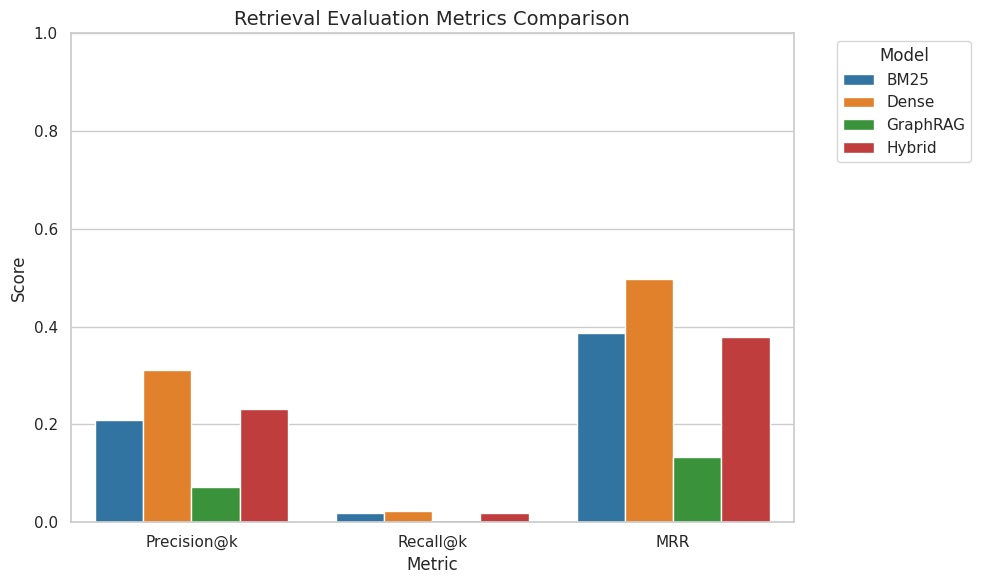

In [118]:
plot_evaluation_results(evaluation_results)

### Evaluate performance **scored at k = 5**

In this section we evaluate the different retrieval strategies using 5 returned chunks. For the calcalation of the Precision, Recall and Reciprocal Rank we take the relevancy score of the chunk into account.

**Precision@k (Graded)**: This will be the sum of the relevance scores of the retrieved items in the top k positions, divided by k.

**Recall@k (Graded)**: This will be the sum of the relevance scores of the retrieved items in the top k positions, divided by the total sum of relevance scores for that question in the ground truth.

**MRR (Graded & Cumulative)**: We'll iterate through the retrieved items, summing their relevance scores. The reciprocal rank will be calculated at the first position where this cumulative sum is >= 1.0. If the sum never reaches 1.0, the MRR is 0.

In [119]:
def precision_at_k(retrieved_ids, ground_truth_scores_dict, k):
    retrieved_k = retrieved_ids[:k]
    achieved_score_at_k = sum(ground_truth_scores_dict.get(cid, 0.0) for cid in retrieved_k)
    return achieved_score_at_k / k

def recall_at_k(retrieved_ids, ground_truth_scores_dict, k):
    retrieved_k = retrieved_ids[:k]
    achieved_score_at_k = sum(ground_truth_scores_dict.get(cid, 0.0) for cid in retrieved_k)

    total_possible_score = sum(score for score in ground_truth_scores_dict.values() if score > 0)

    if total_possible_score == 0:
        # If there are no relevant items in the ground truth,
        return 0.0
    return achieved_score_at_k / total_possible_score

def mrr_graded_cumulative(retrieved_ids, ground_truth_scores_dict):
    current_score_sum = 0.0
    for rank, cid in enumerate(retrieved_ids, start=1):
        score = ground_truth_scores_dict.get(cid, 0.0)
        if score > 0:  # Only consider items with positive relevance
            current_score_sum += score
            if current_score_sum >= 1.0:
                return 1 / rank
    return 0.0

In [120]:
def evaluate_models_graded(Q_A_ground_thruth_relevancy_dict, top_k=5, **retrieval_args):
    # Define retrieval methods
    methods = {
        "BM25": lambda q: retrieve_bm25(q, retrieval_args["bm25_en"], retrieval_args["bm25_de"], retrieval_args["en_docs"], retrieval_args["de_docs"], top_k),
        "Dense": lambda q: retrieve_dense_faiss(q, retrieval_args["dense_model"], retrieval_args["faiss_index"], retrieval_args["dense_df"], top_k),
        "GraphRAG": lambda q: retrieve_graphrag_detailed(q, retrieval_args["model"], retrieval_args["index"], retrieval_args["keys"],
                                           retrieval_args["summaries"], retrieval_args["df"], retrieval_args["doc_entities"],
                                           retrieval_args["community_map"], top_k),
        "Hybrid": lambda q: retrieve_hybrid(q, **retrieval_args, top_k=top_k)
    }

    # Store metric scores per method
    scores = {m: {"Precision@k": [], "Recall@k": [], "MRR": []} for m in methods}

    for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
        query = data["question"]
        # This dictionary contains all ground truth chunk_ids and their scores (0, 0.5, 1)
        ground_truth_scores = data["ground_truth_relevance"]

        # For display purposes, filter to positive scores
        ground_truth_positive_scores = {cid: score for cid, score in ground_truth_scores.items() if score > 0}

        print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")
        print(f"Ground truth scores (>0): {ground_truth_positive_scores}")

        for name, retriever in methods.items():
            try:
                retrieved_df = retriever(query)
                if "unique_chunk_id" not in retrieved_df.columns:
                     retrieved_ids = []
                else:
                    retrieved_ids = retrieved_df["unique_chunk_id"].tolist()
            except Exception as e:
                print(f"  {name}: Error -> {e}")
                scores[name]["Precision@k"].append(0.0)
                scores[name]["Recall@k"].append(0.0)
                scores[name]["MRR"].append(0.0)
                continue

            print(f"  {name}: {len(retrieved_ids)} chunks -> {retrieved_ids[:top_k]}{'...' if len(retrieved_ids) > top_k else ''}")

            # Compute metrics using the graded functions
            scores[name]["Precision@k"].append(precision_at_k(retrieved_ids, ground_truth_scores, top_k))
            scores[name]["Recall@k"].append(recall_at_k(retrieved_ids, ground_truth_scores, top_k))
            scores[name]["MRR"].append(mrr_graded_cumulative(retrieved_ids, ground_truth_scores))

    # Compute average across all questions, ignoring NaNs if they were used for errors
    avg_scores = {
        m: {metric: round(np.nanmean(values), 4) if values else 0.0 for metric, values in metrics.items()}
        for m, metrics in scores.items()
    }

    return avg_scores

In [128]:
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer(model_name, device=device)

In [129]:
evaluation_results = evaluate_models_graded(
	Q_A_ground_thruth_relevancy_dict,
	top_k=5,
	bm25_en=bm25_en, bm25_de=bm25_de, en_docs=en_docs, de_docs=de_docs,
	dense_model=dense_model, faiss_index=faiss_index, dense_df=dense_df,
	model=model, index=index, keys=keys, summaries=summaries, df=df,
	doc_entities=doc_entities, community_map=community_map
)


Q1: Who was president of ETH in 2003?
Ground truth scores (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}
  BM25: 5 chunks -> ['3479_02', '1522_04', '3953_05', '4183_00', '1564_00']
  Dense: 5 chunks -> ['4183_05', '1298_05', '2702_05', '4183_04', '2175_04']
  GraphRAG: 5 chunks -> ['3775_00', '2538_00', '1889_02', '0895_01', '2857_02

Below the evaluation function is executed for each retrieval method, printing the final performance metrics for each method.

In [130]:
for model, metrics in evaluation_results.items():
	print(f"\n{model} Evaluation:")
	for metric, value in metrics.items():
		print(f"{metric}: {value:.4f}")


BM25 Evaluation:
Precision@k: 0.1080
Recall@k: 0.0184
MRR: 0.0980

Dense Evaluation:
Precision@k: 0.1760
Recall@k: 0.0235
MRR: 0.1960

GraphRAG Evaluation:
Precision@k: 0.0440
Recall@k: 0.0040
MRR: 0.0360

Hybrid Evaluation:
Precision@k: 0.1280
Recall@k: 0.0196
MRR: 0.1120


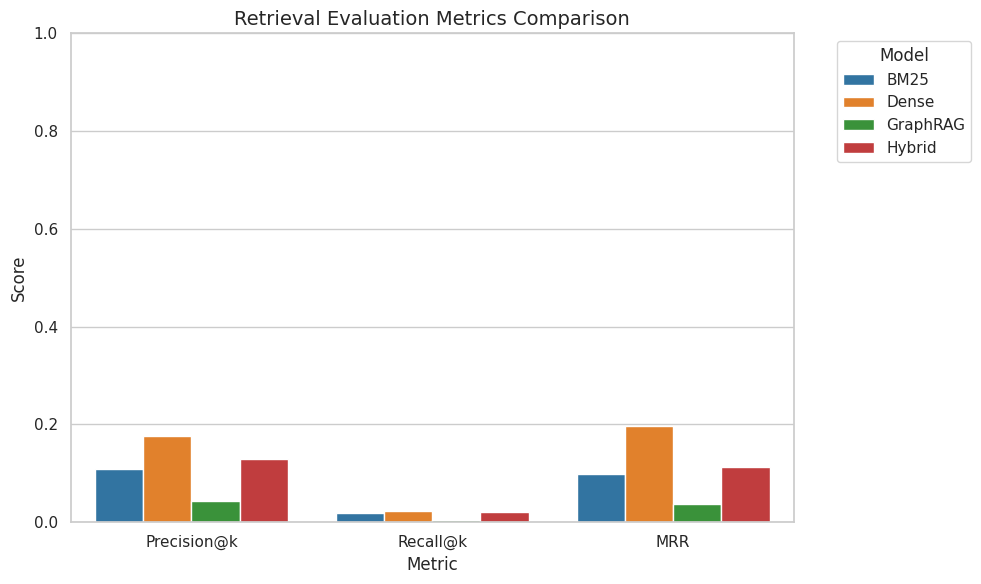

In [131]:
plot_evaluation_results(evaluation_results)

### Evaluate performance **scored at k = 20**

In this section the process is as in the previous section with the top 20 chunks instead of the top five.

In [124]:
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer(model_name, device=device)

In [125]:
evaluation_results = evaluate_models_graded(
	Q_A_ground_thruth_relevancy_dict,
	top_k=20,
	bm25_en=bm25_en, bm25_de=bm25_de, en_docs=en_docs, de_docs=de_docs,
	dense_model=dense_model, faiss_index=faiss_index, dense_df=dense_df,
	model=model, index=index, keys=keys, summaries=summaries, df=df,
	doc_entities=doc_entities, community_map=community_map
)


Q1: Who was president of ETH in 2003?
Ground truth scores (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}
  BM25: 20 chunks -> ['3479_02', '1522_04', '3953_05', '4183_00', '1564_00', '3404_03', '3466_02', '4126_01', '2264_04', '0241_17', '2436_01', '4325_00', '2397_03', '3526_02', '2750_01', '2358_00', '3553_08', '4026_06', '2023_04',

Below the evaluation function is executed for each retrieval method, printing the final performance metrics for each method.

In [126]:
for model, metrics in evaluation_results.items():
	print(f"\n{model} Evaluation:")
	for metric, value in metrics.items():
		print(f"{metric}: {value:.4f}")


BM25 Evaluation:
Precision@k: 0.0900
Recall@k: 0.0551
MRR: 0.1461

Dense Evaluation:
Precision@k: 0.1210
Recall@k: 0.0559
MRR: 0.2110

GraphRAG Evaluation:
Precision@k: 0.0650
Recall@k: 0.0371
MRR: 0.0953

Hybrid Evaluation:
Precision@k: 0.1030
Recall@k: 0.0544
MRR: 0.1456


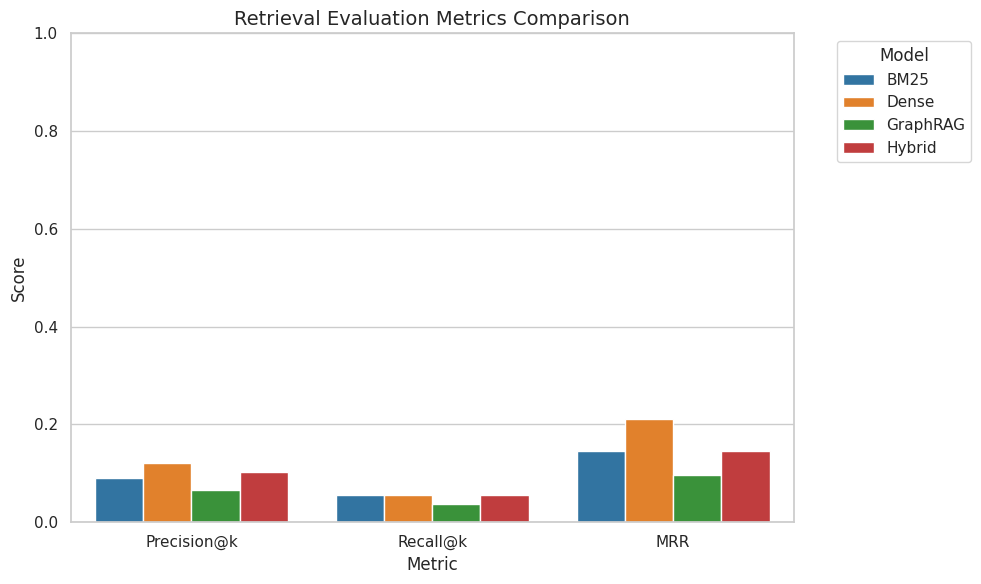

In [127]:
plot_evaluation_results(evaluation_results)

## 2.7 Retriever Improvements

**Add text about not continuing the GraphRetriever (bad + too slow) and try to improve with other methodsç**

### Possible Improvements using Rewriting + Extension and HyDE (Hypothetical Document Embeddings)

In [191]:
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dense_model = SentenceTransformer(model_name, device=device)

In [132]:
from typing import List, Literal
from pydantic import BaseModel, Field
from openai import OpenAI

In [139]:
import openai
from google.colab import userdata

api_key = userdata.get('openai_advAI')

In [136]:
# --- 1. Pydantic Models for LLM Output (ensure these are defined correctly) ---
class GeneratedQueryVariations(BaseModel):
    variations: List[str] = Field(
        description="A list of three diverse query variations aimed at improving search recall and precision.",
        min_length=3,
        max_length=3
    )

class GeneratedHydeDocuments(BaseModel):
    documents: List[str] = Field(
        description="A list of three diverse, concise, and relevant hypothetical documents that comprehensively answer the original query.",
        min_length=3,
        max_length=3
    )

In [146]:
# --- 2. OpenAI Function for Generating Variations ---
# Note: You'll need to have the OpenAI API key set as an environment variable OPENAI_API_KEY
# or pass it to the OpenAI client.

def get_openai_client(api_key: str = None):
    """Initializes and returns an OpenAI client."""
    return OpenAI(api_key=api_key)

def generate_variations_openai(
    original_query: str,
    variation_type: Literal["queries", "hyde_documents"],
    num_variations: int = 3,
    llm_model: str = "gpt-4o",
    client: OpenAI = None,
    api_key: str = None
) -> List[str]:
    """
    Generates multiple query variations or hypothetical documents using OpenAI LLM.
    """
    if client is None:
        client = get_openai_client(api_key=api_key) # Use passed api_key

    if num_variations != 3:
        # This warning is good, Pydantic models enforce 3.
        print(f"Warning: Pydantic models are set for 3 variations. Generating {num_variations} might conflict if not 3.")

    json_structure_example_queries = f"""
Your response MUST be a JSON object with a single key "variations".
The value of "variations" MUST be a list of exactly {num_variations} strings, where each string is a query variation.
Example for {num_variations} variations:
{{
  "variations": [
    "query text 1",
    "query text 2",
    "query text 3"
  ]
}}
"""
    json_structure_example_hyde = f"""
Your response MUST be a JSON object with a single key "documents".
The value of "documents" MUST be a list of exactly {num_variations} strings, where each string is a hypothetical document.
Example for {num_variations} variations:
{{
  "documents": [
    "hypothetical document text 1...",
    "hypothetical document text 2...",
    "hypothetical document text 3..."
  ]
}}
"""

    if variation_type == "queries":
        type_desc = "search query variations. Each query should explore a different facet or phrasing of the original query, aiming for comprehensive coverage and diversity."
        json_structure_guidance = json_structure_example_queries
    elif variation_type == "hyde_documents":
        type_desc = "hypothetical documents. Each document should be a concise, ideal answer to the original query, rich in relevant keywords and concepts, and diverse from the others."
        json_structure_guidance = json_structure_example_hyde
    else:
        raise ValueError("variation_type must be 'queries' or 'hyde_documents'")

    system_prompt_template = """
You are an expert in search query optimization and information retrieval.
Your primary task is to generate exactly {num_variations} diverse and effective {type_description} based on the original user query.
These variations are crucial for retrieving the most relevant documents from a corpus.

{json_guidance}

Ensure your output strictly adheres to this JSON structure. Do not include any other text, explanations, or apologies.
"""
    system_prompt = system_prompt_template.format(
        num_variations=num_variations,
        type_description=type_desc,
        json_guidance=json_structure_guidance
    )
    user_prompt = f"Original Query: '{original_query}'"

    try:
        response = client.chat.completions.create(
            model=llm_model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={"type": "json_object"},
            temperature=0.6,
        )

        json_response_str = response.choices[0].message.content

        if variation_type == "queries":
            parsed_output = GeneratedQueryVariations.model_validate_json(json_response_str)
            return parsed_output.variations
        else: # hyde_documents
            parsed_output = GeneratedHydeDocuments.model_validate_json(json_response_str)
            return parsed_output.documents

    except Exception as e:
        print(f"Error calling OpenAI or parsing response: {e}")
        # Fallback to simple placeholder variations in case of API error
        # Using a more distinct fallback to differentiate from potential successful but simple LLM output
        error_prefix = "ERROR_FALLBACK_"
        if variation_type == "queries":
            return [f"{error_prefix}{original_query} - variation {i+1}" for i in range(num_variations)]
        else: # hyde_documents
            return [f"{error_prefix}Hypothetical document for {original_query} - version {i+1}. This document details..." for i in range(num_variations)]

In [151]:
test_query = "Is ETH developing an AI system to develop treatments in the field of medicine?"
print("Query:", test_query)
print("Variations (queries):")
pprint.pprint(generate_variations_openai(test_query, variation_type="queries", api_key=api_key))
print("HyDE Documents:")
pprint.pprint(generate_variations_openai(test_query, variation_type="hyde_documents", api_key=api_key))

Query: Is ETH developing an AI system to develop treatments in the field of medicine?
Variations (queries):
['ETH AI initiatives in medical treatment development',
 'Does ETH use artificial intelligence for medical research?',
 "ETH's role in AI-driven advancements in medicine"]
HyDE Documents:
['ETH Zurich, a leading science and technology university in Switzerland, is '
 'actively engaged in the development of AI systems aimed at revolutionizing '
 'medical treatments. Their research focuses on leveraging machine learning '
 'algorithms to analyze complex biological data, which can expedite the '
 "discovery of new therapies and personalized medicine approaches. ETH's "
 'interdisciplinary teams are collaborating with healthcare professionals to '
 'ensure these AI-driven solutions are both effective and safe for clinical '
 'use.',
 'The Swiss Federal Institute of Technology (ETH Zurich) is at the forefront '
 'of integrating artificial intelligence into the medical field. Their cur

In [171]:
# 4. New `_multi` Retrieval Functions
def retrieve_bm25_rewrite_multi(query, bm25_en, bm25_de, en_docs, de_docs, top_k=5,
                                detect_language_func=None, tokenize_func=None, translate_query_func=None):
    if not all([detect_language_func, tokenize_func, translate_query_func]):
        raise ValueError("detect_language, tokenize, and translate_query functions must be provided.")

    rewritten_queries = generate_variations_openai(query, variation_type="queries", api_key=api_key, num_variations=3)

    # Initialize total scores
    # Ensure index alignment if en_docs/de_docs can be empty
    en_total_scores = pd.Series(0.0, index=en_docs.index if not en_docs.empty else None, dtype=float)
    de_total_scores = pd.Series(0.0, index=de_docs.index if not de_docs.empty else None, dtype=float)

    for rewritten_q_text in rewritten_queries:
        # detected_lang = detect_language_func(rewritten_q_text) # Or use original query's lang
        detected_lang = detect_language_func(query) # Assuming rewrites are in original lang
        tokens = tokenize_func(rewritten_q_text)

        if detected_lang == 'en':
            if bm25_en and not en_docs.empty:
                en_total_scores += pd.Series(bm25_en.get_scores(tokens), index=en_docs.index)
            if bm25_de and not de_docs.empty:
                translated_q_de = translate_query_func(rewritten_q_text, 'en', 'de')
                de_tokens = tokenize_func(translated_q_de)
                de_total_scores += pd.Series(bm25_de.get_scores(de_tokens), index=de_docs.index)
        elif detected_lang == 'de':
            if bm25_de and not de_docs.empty:
                de_total_scores += pd.Series(bm25_de.get_scores(tokens), index=de_docs.index)
            if bm25_en and not en_docs.empty:
                translated_q_en = translate_query_func(rewritten_q_text, 'de', 'en')
                en_tokens = tokenize_func(translated_q_en)
                en_total_scores += pd.Series(bm25_en.get_scores(en_tokens), index=en_docs.index)
        else: # Fallback
            print(f"Warning (BM25 Rewrite Multi): Lang '{detected_lang}' for '{rewritten_q_text[:20]}...' not handled. Scoring on both.")
            if bm25_en and not en_docs.empty: en_total_scores += pd.Series(bm25_en.get_scores(tokens), index=en_docs.index)
            if bm25_de and not de_docs.empty: de_total_scores += pd.Series(bm25_de.get_scores(tokens), index=de_docs.index)

    num_queries = len(rewritten_queries)
    en_avg_scores = en_total_scores / num_queries if num_queries > 0 else en_total_scores
    de_avg_scores = de_total_scores / num_queries if num_queries > 0 else de_total_scores

    en_res = pd.DataFrame()
    if not en_docs.empty and not en_avg_scores.empty:
        en_res = en_docs.copy()
        en_res['score'] = min_max_normalize(en_avg_scores)

    de_res = pd.DataFrame()
    if not de_docs.empty and not de_avg_scores.empty:
        de_res = de_docs.copy()
        de_res['score'] = min_max_normalize(de_avg_scores)

    if not en_res.empty and not de_res.empty: combined_results = pd.concat([en_res, de_res])
    elif not en_res.empty: combined_results = en_res
    elif not de_res.empty: combined_results = de_res
    else: return pd.DataFrame(columns=['unique_chunk_id', 'score'])

    return combined_results.sort_values('score', ascending=False).head(top_k)


def retrieve_bm25_hyde_multi(query, bm25_en, bm25_de, en_docs, de_docs, top_k=5,
                             detect_language_func=None, tokenize_func=None, translate_query_func=None):
    if not all([detect_language_func, tokenize_func, translate_query_func]):
        raise ValueError("detect_language, tokenize, and translate_query functions must be provided.")

    hyde_documents = generate_variations_openai(query, variation_type="hyde_documents",
                                                api_key=api_key, num_variations=3)

    en_total_scores = pd.Series(0.0, index=en_docs.index if not en_docs.empty else None, dtype=float)
    de_total_scores = pd.Series(0.0, index=de_docs.index if not de_docs.empty else None, dtype=float)

    original_query_lang = detect_language_func(query)

    for hyde_doc_text in hyde_documents:
        # Assume HyDE docs are generated in the original query's language
        # or a pivot language like English if the LLM is optimized for it.
        # For simplicity, let's use original_query_lang as the source lang for HyDE doc.

        if original_query_lang == 'en':
            hyde_tokens_en = tokenize_func(hyde_doc_text)
            if bm25_en and not en_docs.empty:
                en_total_scores += pd.Series(bm25_en.get_scores(hyde_tokens_en), index=en_docs.index)
            if bm25_de and not de_docs.empty:
                translated_hyde_de = translate_query_func(hyde_doc_text, 'en', 'de')
                hyde_tokens_de = tokenize_func(translated_hyde_de)
                de_total_scores += pd.Series(bm25_de.get_scores(hyde_tokens_de), index=de_docs.index)
        elif original_query_lang == 'de':
            hyde_tokens_de = tokenize_func(hyde_doc_text)
            if bm25_de and not de_docs.empty:
                de_total_scores += pd.Series(bm25_de.get_scores(hyde_tokens_de), index=de_docs.index)
            if bm25_en and not en_docs.empty:
                translated_hyde_en = translate_query_func(hyde_doc_text, 'de', 'en')
                hyde_tokens_en = tokenize_func(translated_hyde_en)
                en_total_scores += pd.Series(bm25_en.get_scores(hyde_tokens_en), index=en_docs.index)
        else: # Fallback: tokenize original HyDE doc and score on both if available
            print(f"Warning (BM25 HyDE Multi): Lang '{original_query_lang}' for HyDE doc not handled. Scoring on both.")
            hyde_tokens = tokenize_func(hyde_doc_text)
            if bm25_en and not en_docs.empty: en_total_scores += pd.Series(bm25_en.get_scores(hyde_tokens), index=en_docs.index)
            if bm25_de and not de_docs.empty: de_total_scores += pd.Series(bm25_de.get_scores(hyde_tokens), index=de_docs.index)


    num_docs = len(hyde_documents)
    en_avg_scores = en_total_scores / num_docs if num_docs > 0 else en_total_scores
    de_avg_scores = de_total_scores / num_docs if num_docs > 0 else de_total_scores

    en_res = pd.DataFrame()
    if not en_docs.empty and not en_avg_scores.empty:
        en_res = en_docs.copy()
        en_res['score'] = min_max_normalize(en_avg_scores)

    de_res = pd.DataFrame()
    if not de_docs.empty and not de_avg_scores.empty:
        de_res = de_docs.copy()
        de_res['score'] = min_max_normalize(de_avg_scores)

    if not en_res.empty and not de_res.empty: combined_results = pd.concat([en_res, de_res])
    elif not en_res.empty: combined_results = en_res
    elif not de_res.empty: combined_results = de_res
    else: return pd.DataFrame(columns=['unique_chunk_id', 'score'])

    return combined_results.sort_values('score', ascending=False).head(top_k)

In [186]:
# Test Rewriting and Extension
test_query = "Is ETH developing an AI system to develop treatments in the field of medicine?"
bm25_results_extended = retrieve_bm25_rewrite_multi(test_query, bm25_en, bm25_de, en_docs, de_docs, top_k=5,
                                                    detect_language_func=detect_language,
                                                    tokenize_func=tokenize,
                                                    translate_query_func=translate_query)
display(bm25_results_extended[['unique_chunk_id', 'chunk_text', 'score', 'title']])

,unique_chunk_id,chunk_text,score,title
12768,1911_00,Das neue Gebäude GLC ist für die ETH Zürich un...,1.000000,Eth zuerich bezieht neubau im gloriarank spaet...
12188,4217_01,(Photograph: © private)\nDr Michael Moor (*199...,1.000000,Six professors appointed
10765,1334_01,## Ein Drittel ETH-Professuren beteiligt\nAuf ...,0.933739,Gemeinsam fuer die medizin der zukunft
10136,1263_09,(Foto: ETH Zürich / Giulia Marthaler)\nProf. D...,0.928763,Zwoelf professorinnen und professoren ernannt
10236,1272_11,## Serie «Künstliche Intelligenz für die Schwe...,0.918984,Mit stroh und hanf zu klimafreundlichen renova...


In [187]:
# Test HyDE
test_query = "Is ETH developing an AI system to develop treatments in the field of medicine?"
bm25_results_hyde = retrieve_bm25_hyde_multi(test_query, bm25_en, bm25_de, en_docs, de_docs, top_k=5,
                                                    detect_language_func=detect_language,
                                                    tokenize_func=tokenize,
                                                    translate_query_func=translate_query)
display(bm25_results_hyde[['unique_chunk_id', 'chunk_text', 'score', 'title']])

,unique_chunk_id,chunk_text,score,title
1813,0229_09,## Profitieren von künstlicher Intelligenz\nGr...,1.000000,Wissenschaftler entwickeln hochpraezisen digit...
12188,4217_01,(Photograph: © private)\nDr Michael Moor (*199...,1.000000,Six professors appointed
12225,4220_08,## “Artificial intelligence for Switzerland” s...,0.988703,New app unmasks forged documents
12253,4223_11,## “Artificial intelligence for Switzerland” s...,0.987959,Climate friendly renovations using straw and hemp
11981,4194_06,## “Artificial Intelligence for Switzerland” s...,0.987959,Ai designs new drugs based on protein structures


In [172]:
def retrieve_dense_faiss_rewrite_multi(query, model, dense_embeddings, dense_df, top_k=5):
    # dense_embeddings is the N x D numpy array of all document embeddings
    # dense_df is the DataFrame containing document info, indexed consistently with dense_embeddings
    if dense_embeddings is None or dense_df.empty:
        return pd.DataFrame(columns=['unique_chunk_id', 'chunk_text', 'score', 'title'])

    rewritten_queries = generate_variations_openai(query, variation_type="queries", api_key=api_key, num_variations=3)
    total_scores = np.zeros(len(dense_df))

    for rewritten_q_text in rewritten_queries:
        query_vec = model.encode([rewritten_q_text], convert_to_numpy=True, normalize_embeddings=True)
        # Calculate cosine similarity: query_vec (1,D) @ dense_embeddings.T (D,N) -> (1,N)
        current_scores = (query_vec @ dense_embeddings.T).flatten()
        total_scores += current_scores

    num_queries = len(rewritten_queries)
    avg_scores_values = total_scores / num_queries if num_queries > 0 else total_scores
    avg_scores = pd.Series(avg_scores_values, index=dense_df.index)

    normalized_scores = min_max_normalize(avg_scores)

    results_df = dense_df.copy()
    results_df['score'] = normalized_scores

    # Sort by score and get top_k
    top_results = results_df.sort_values('score', ascending=False).head(top_k)
    return top_results[['unique_chunk_id', 'chunk_text', 'score', 'title']]


def retrieve_dense_faiss_hyde_multi(query, model, dense_embeddings, dense_df, top_k=5):
    if dense_embeddings is None or dense_df.empty:
        return pd.DataFrame(columns=['unique_chunk_id', 'chunk_text', 'score', 'title'])

    hyde_documents = generate_variations_openai(query, variation_type="hyde_documents",
                                                api_key=api_key, num_variations=3)
    total_scores = np.zeros(len(dense_df))

    for hyde_doc_text in hyde_documents:
        hyde_vec = model.encode([hyde_doc_text], convert_to_numpy=True, normalize_embeddings=True)
        current_scores = (hyde_vec @ dense_embeddings.T).flatten()
        total_scores += current_scores

    num_docs = len(hyde_documents)
    avg_scores_values = total_scores / num_docs if num_docs > 0 else total_scores
    avg_scores = pd.Series(avg_scores_values, index=dense_df.index)

    normalized_scores = min_max_normalize(avg_scores)

    results_df = dense_df.copy()
    results_df['score'] = normalized_scores

    top_results = results_df.sort_values('score', ascending=False).head(top_k)
    return top_results[['unique_chunk_id', 'chunk_text', 'score', 'title']]

In [192]:
# Test Rewriting and Extension
test_query = "Is ETH developing an AI system to develop treatments in the field of medicine?"
print("Query:", query)
dense_results = retrieve_dense_faiss_rewrite_multi(test_query, dense_model, dense_embeddings, dense_df, top_k=5)
display(dense_results)

Query: Is ETH developing an AI system to develop treatments in the field of medicine?


,unique_chunk_id,chunk_text,score,title
12004,1645_01,Für Forschende der ETH Zürich eröffnet die Per...,1.000000,Diskussion ueber personalisierte medizin
27083,4220_08,## “Artificial intelligence for Switzerland” s...,0.974391,New app unmasks forged documents
3238,0409_03,Die konkreten Teilprojekte sollen im kommenden...,0.972225,Wissenschaft fuer unabhaengigkeit im alter
19897,3302_00,"ETH News: ETH Zurich already has delegates, or...",0.971129,Interview christian wolfrum associate vice pre...
20044,3322_00,ETH Zurich has been offering 100 places to stu...,0.963241,Bachelor of medicine


In [193]:
# Test HyDE
test_query = "Is ETH developing an AI system to develop treatments in the field of medicine?"
print("Query:", query)
dense_results = retrieve_dense_faiss_hyde_multi(test_query, dense_model, dense_embeddings, dense_df, top_k=5)
display(dense_results)

Query: Is ETH developing an AI system to develop treatments in the field of medicine?


,unique_chunk_id,chunk_text,score,title
10766,1334_02,Für die ETH Zürich ist aber klar: Moderne medi...,1.000000,Gemeinsam fuer die medizin der zukunft
12003,1645_00,Personalisierten Medizin erforscht die Grundla...,0.991520,Diskussion ueber personalisierte medizin
26405,4149_02,"Now scientists at ETH Zurich, together with re...",0.981375,Artificial intelligence finds ways to develop ...
26413,4149_10,Atz is now involved in this further developmen...,0.976183,Artificial intelligence finds ways to develop ...
27083,4220_08,## “Artificial intelligence for Switzerland” s...,0.968837,New app unmasks forged documents


In [173]:
# 5. Evaluation Function (Updated for _multi methods
def evaluate_models_graded_extended(Q_A_ground_thruth_relevancy_dict, top_k=5, **retrieval_args):
    methods = {
        "BM25_Base": lambda q: retrieve_bm25(q, retrieval_args["bm25_en"], retrieval_args["bm25_de"],
                                             retrieval_args["en_docs"], retrieval_args["de_docs"], top_k=top_k),
        "BM25_Rewrite_Multi": lambda q: retrieve_bm25_rewrite_multi(q, retrieval_args["bm25_en"], retrieval_args["bm25_de"],
                                                                    retrieval_args["en_docs"], retrieval_args["de_docs"], top_k=top_k,
                                                                    detect_language_func=retrieval_args["detect_language_func"],
                                                                    tokenize_func=retrieval_args["tokenize_func"],
                                                                    translate_query_func=retrieval_args["translate_query_func"]),
        "BM25_HyDE_Multi": lambda q: retrieve_bm25_hyde_multi(q, retrieval_args["bm25_en"], retrieval_args["bm25_de"],
                                                              retrieval_args["en_docs"], retrieval_args["de_docs"], top_k=top_k,
                                                              detect_language_func=retrieval_args["detect_language_func"],
                                                              tokenize_func=retrieval_args["tokenize_func"],
                                                              translate_query_func=retrieval_args["translate_query_func"]),
        "Dense_Base": lambda q: retrieve_dense_faiss(q, retrieval_args["dense_model"], retrieval_args["faiss_index"],
                                                    retrieval_args["dense_df"], top_k=top_k), #
        "Dense_Rewrite_Multi": lambda q: retrieve_dense_faiss_rewrite_multi(q, retrieval_args["dense_model"],
                                                                           retrieval_args["dense_embeddings"],
                                                                           retrieval_args["dense_df"], top_k=top_k),
        "Dense_HyDE_Multi": lambda q: retrieve_dense_faiss_hyde_multi(q, retrieval_args["dense_model"],
                                                                     retrieval_args["dense_embeddings"],
                                                                     retrieval_args["dense_df"], top_k=top_k),
    }

    scores = {m: {"Precision@k": [], "Recall@k": [], "MRR": []} for m in methods}

    for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
        query = data["question"]
        ground_truth_scores = data["ground_truth_relevance"]
        ground_truth_positive_scores = {cid: score for cid, score in ground_truth_scores.items() if score > 0}

        print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")
        if ground_truth_positive_scores:
             print(f"Ground truth scores (>0): {ground_truth_positive_scores}")
        else:
             print("Ground truth scores (>0): {} (No relevant items for this query)")

        for name, retriever_func in methods.items():
            retrieved_ids = []
            try:
                # Ensure 'dense_embeddings' is passed if required by the method
                if "Multi" in name and "Dense" in name and "dense_embeddings" not in retrieval_args:
                    raise ValueError(f"Method {name} requires 'dense_embeddings' in retrieval_args.")

                retrieved_df = retriever_func(query)
                if retrieved_df is not None and "unique_chunk_id" in retrieved_df.columns and not retrieved_df.empty:
                    retrieved_ids = retrieved_df["unique_chunk_id"].tolist()
                elif retrieved_df is not None and retrieved_df.empty :
                     print(f"  {name}: Retrieved DataFrame is empty.") # Normal case, no results
                else:
                    print(f"  {name}: Retrieved DataFrame is None or missing 'unique_chunk_id' column.")
            except Exception as e:
                print(f"  {name}: Error -> {e}")
                scores[name]["Precision@k"].append(0.0)
                scores[name]["Recall@k"].append(0.0)
                scores[name]["MRR"].append(0.0)
                continue

            print(f"  {name}: {len(retrieved_ids)} chunks -> {retrieved_ids[:top_k]}{'...' if len(retrieved_ids) > top_k else ''}")

            scores[name]["Precision@k"].append(precision_at_k(retrieved_ids, ground_truth_scores, top_k))
            scores[name]["Recall@k"].append(recall_at_k(retrieved_ids, ground_truth_scores, top_k))
            scores[name]["MRR"].append(mrr_graded_cumulative(retrieved_ids, ground_truth_scores))

    avg_scores = {
        m: {metric: round(np.nanmean(values), 4) if values else 0.0 for metric, values in metrics.items()}
        for m, metrics in scores.items()
    }
    return avg_scores

In [178]:
#  Plotting Function
def plot_evaluation_results_extended(results_dict, title="Retrieval Evaluation Metrics Comparison"):
    data = []
    for model_name, metrics in results_dict.items():
        for metric_name, value in metrics.items():
            data.append({
                "Model": model_name,
                "Metric": metric_name,
                "Score": value
            })

    df_plot = pd.DataFrame(data)

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))

    ax = sns.barplot(data=df_plot, x="Metric", y="Score", hue="Model", palette="tab10")
    ax.set_title(title, fontsize=14)
    ax.set_ylim(0, max(1.0, df_plot["Score"].max() * 1.1))
    plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [ ]:
evaluation_args = {
    "bm25_en": bm25_en, "bm25_de": bm25_de,
    "en_docs": en_docs, "de_docs": de_docs,
    "dense_model": dense_model, "faiss_index": faiss_index, "dense_df": dense_df,
    "detect_language_func": detect_language,
    "tokenize_func": tokenize,
    "translate_query_func": translate_query,
    "dense_embeddings": dense_embeddings
}

extended_evaluation_results = evaluate_models_graded_extended(
    Q_A_ground_thruth_relevancy_dict,
    top_k=20,
    **evaluation_args
)


Q1: Who was president of ETH in 2003?
Ground truth scores (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}
  BM25_Base: 20 chunks -> ['3479_02', '1522_04', '3953_05', '4183_00', '1564_00', '3404_03', '3466_02', '4126_01', '2264_04', '0241_17', '2436_01', '4325_00', '2397_03', '3526_02', '2750_01', '2358_00', '3553_08', '4026_06', '2023

In [ ]:
for model_name, metrics in extended_evaluation_results.items():
    print(f"\n{model_name} Evaluation:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

In [ ]:
plot_evaluation_results_extended(extended_evaluation_results, title="Extended Retrieval Evaluation")

# Comparative Report: Pre-Retrieval and Retrieval Strategies

## Overview

This report compares four retrieval strategies used in a multilingual question-answering system:
1. **BM25** (sparse keyword-based retrieval)  
2. **Dense retrieval** (semantic embedding using SBERT + FAISS)  
3. **GraphRAG** (entity-aware, community-based retrieval)  
4. **Hybrid** (a combination of BM25, Dense, and GraphRAG)  

These methods are evaluated using a set of questions with known relevant document chunks, based on three key metrics: **Precision@k**, **Recall@k**, and **MRR (Mean Reciprocal Rank)**.


## Pre-Retrieval Differences

- **BM25** relies on traditional lexical statistics and indexes raw document text in both English and German. It is highly effective for well-structured documents and queries with exact term overlap.
- **Dense retrieval** indexes semantic embeddings of documents, enabling it to handle paraphrased or loosely worded queries more flexibly, though at the risk of semantic drift.
- **GraphRAG** adds a pre-retrieval phase where documents are converted into a knowledge graph based on named entity co-occurrence. Communities of related entities are detected and summarized, and the summaries are indexed for retrieval.
- **Hybrid retrieval** combines the above approaches, using lexical and semantic matches and expanding context using the graph.


## Retrieval Results and Best-Performing Approach

**Dense retrieval** emerged as the top performer in terms of ranking quality (MRR) and precision, slightly outperforming BM25, particularly when queries required understanding beyond exact keyword matches.

**BM25** remained strong in terms of precision and recall when query phrasing closely matched document text. It was especially effective for factual or date-based queries where exact terms were critical.

**GraphRAG**, while conceptually promising, underperformed across all metrics. Its lower effectiveness is attributed to several factors:
- Loss of detail during community-level summarization  
- Incomplete or inaccurate entity extraction in multilingual or informal text  
- Poor alignment between narrow queries and broad graph-based summaries  

Additionally, GraphRAG is computationally intensive. Graph construction, entity extraction, community detection, and summarization significantly increase the time and resource cost compared to BM25 and Dense methods. This makes it less suitable for real-time or high-throughput systems without optimization.


## How GraphRAG Expands Context

GraphRAG’s core strength lies in **expanding the scope of retrieval** beyond individual passages by organizing information into communities of related entities. When it works well, this enables the model to retrieve **broader context** around a topic (e.g., not just a single mention of “vaccines” but a wider discussion of public health, policy, and outcomes). However, this strength only materializes in **well-structured, entity-dense corpora** and with **global or exploratory queries**. For narrow, fact-based questions, this expansion often introduces irrelevant noise, reducing performance.


## Hybrid vs. Standalone Performance

The **Hybrid retrieval** method, which integrates BM25, Dense, and GraphRAG, performed competitively—combining the precision of BM25 and semantic flexibility of Dense models. However, its **recall remained low**, likely due to overlapping retrievals and lack of coordinated ranking across systems.

It is also the most computationally expensive approach, as it runs all three retrieval methods and merges results. The increased runtime makes it less practical unless response latency is not a concern or reranking justifies the cost. Without a smart fusion strategy or reranker, Hybrid methods may offer only marginal gains at a high cost.


## Conclusion

While **Dense retrieval** currently offers the best balance of flexibility, ranking performance, and computational efficiency, **BM25** remains a strong and interpretable baseline, especially for precise queries. **GraphRAG**, despite its innovative architecture, requires careful tuning, high-quality structured content, and substantial resources to be effective. It may be best suited for exploratory tasks over large, well-curated datasets. The **Hybrid approach** has strong potential for robustness and diversity, but must be enhanced with learned fusion or reranking to justify its computational demands.

Ultimately, the recommended default is **Dense retrieval**, due to its strong results and low overhead. GraphRAG and Hybrid retrieval are promising but should be used selectively based on task complexity, dataset structure, and runtime constraints.
